# Sumário
1. [Introdução](#intro)
1. [Imports e Funções](#imports)
3. [Base de Dados](#database)
    1. [Visualização Inicial](#visuini)
    2. [Limpeza dos Dados](#limpeza)
4. [Visualização de Dados](#visu)
    1. [Visualização do GDP](#visugdp)
    2. [Visualização da Expectativa de Vida](#visuvida)
    3. [Visualização Extra](#visuextra)
        1. [Visualização da Taxa de Desemprego](#visudes)
        2. [Visualização da Prevalência do HIV](#visuhiv)
        3. [Visualização da Taxa de Inflação](#visuinf)
5. [Testes de Hipóteses](#testes)
    1. [Teste da Expectativa de Vida](#testevida)
    2. [Teste da Taxa de Desemprego](#testedes)
    3. [Teste da Prevalência do HIV](#testehiv)
    4. [Teste da Taxa de Inflação](#testeinf)
    5. [Correlação entre Prevalência do HIV e Expectativa de Vida](#hivvida)
6. [Separação dos Grupos](#grupos)
7. [Fit dos Modelos](#fit)
8. [Avaliação dos Modelos](#aval)
    1. [Visualização do MSE](#mse)
        1. [MSE da Regressão Linear](#msereglin)
        2. [MSE do Lasso](#mselasso)
        3. [MSE do Ridge](#mseridge)
        4. [MSE do KNN](#mseknn)
    2. [Avaliação Usando o Grupo de Teste](#grupoteste)
        1. [Regressão Linear no Grupo de Teste](#reglinteste)
        2. [Lasso no Grupo de Teste](#lassoteste)
        3. [Ridge no Grupo de Teste](#ridgeteste)
        4. [KNN no Grupo de Teste](#knnteste)
9. [Conclusão](#concl)

## 1. Introdução <a name="intro"></a>

Nesse notebook iremos utilizar uma base de dados com algumas informações (como Prevalência do HIV na população adulta, Expectativa de Vida, o próprio PIB, que aqui será chamado pelo nome em inglês, GDP, entre outras) sobre os países, para tentar entender desses fatores, quais têm mais correlação com PIB de um país.

Iremos tentar o caminho da Regressão Linear Múltipla, Lasso, Ridge e KNN. Depois iremos avaliar os modelos.

## 2. Imports e Funções <a name="imports"></a>


In [1]:
from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.distributions.empirical_distribution import ECDF

from scipy import stats as ss

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Padronização dos gráficos para facilitar visualização.

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

Força o gráfica a ser desenhado no próprio notebook.

In [3]:
plt.ion()

Função que retira as linhas das bordas direita e superior dos gráficos.

In [4]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

Função que calcula o bootstrap com 5000 valores do conjunto de dados x passado.

In [5]:
def bootstrap_mean(x, n=5000):
    size = len(x)
    values = np.zeros(n)
    for i in range(n):
        sample = np.random.choice(x, size=size, replace=True)
        values[i] = sample.mean()
    return values

Função que calcula o bootstrap com 5000 valores do MSE (Erro Médio Quadrado) do modelo passado.

In [6]:
def bootstrap_mse(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X[idx]
        yb = y[idx]
        values[i] = mean_squared_error(yb, model.predict(Xb))
    return values

Função que calcula o bootstrap com 5000 valores do score do modelo passado. Ela não será utilizada nesse notebook, mas pode ser útil caso o leitor queira utilizar outra métrica para avaliar os modelos.

In [7]:
def bootstrap_score(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X[idx]
        yb = y[idx]
        values[i] = model.score(Xb, yb)
    return values

## 3. Base de Dados <a name="database"></a>

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSVs/countries.csv', encoding='utf-8', sep=';')

### 1. Visualização Inicial <a name="visuini"></a>


Algumas colunas como "Oil - exports(bbl/day)" e "Oil - imports(bbl/day)" possuem muitos NaNs.

In [9]:
df.isna().sum().sort_values(ascending=False)

Oil - imports(bbl/day)                            217
Oil - exports(bbl/day)                            205
Oil - proved reserves(bbl)                        166
Natural gas - proved reserves(cu m)               166
Natural gas - production(cu m)                    156
Natural gas - consumption(cu m)                   155
Natural gas - exports(cu m)                       155
Natural gas - imports(cu m)                       155
Public debt(% of GDP)                             155
Railways(km)                                      129
Investment (gross fixed)(% of GDP)                117
Reserves of foreign exchange & gold               116
HIV/AIDS - deaths                                 115
Current account balance                           114
Industrial production growth rate(%)               99
HIV/AIDS - people living with HIV/AIDS             99
Military expenditures - percent of GDP(%)          98
HIV/AIDS - adult prevalence rate(%)                95
Military expenditures - doll

In [10]:
df.shape

(263, 45)

In [11]:
df.dropna().shape

(18, 45)

Se fôssemos tirar todas linhas que possuem ao menos algum NaN ficaríamos com um DataFrame minúsculo.

In [12]:
df.shape[0] - df.dropna().shape[0]

245

In [13]:
df.dropna().head()

,Country,Area(sq km),Birth rate(births/1000 population),Current account balance,Death rate(deaths/1000 population),Debt - external,Electricity - consumption(kWh),Electricity - production(kWh),Exports,GDP,GDP - per capita,GDP - real growth rate(%),HIV/AIDS - adult prevalence rate(%),HIV/AIDS - deaths,HIV/AIDS - people living with HIV/AIDS,Highways(km),Imports,Industrial production growth rate(%),Infant mortality rate(deaths/1000 live births),Inflation rate (consumer prices)(%),Internet hosts,Internet users,Investment (gross fixed)(% of GDP),Labor force,Life expectancy at birth(years),Military expenditures - dollar figure,Military expenditures - percent of GDP(%),Natural gas - consumption(cu m),Natural gas - exports(cu m),Natural gas - imports(cu m),Natural gas - production(cu m),Natural gas - proved reserves(cu m),Oil - consumption(bbl/day),Oil - exports(bbl/day),Oil - imports(bbl/day),Oil - production(bbl/day),Oil - proved reserves(bbl),Population,Public debt(% of GDP),Railways(km),Reserves of foreign exchange & gold,Telephones - main lines in use,Telephones - mobile cellular,Total fertility rate(children born/woman),Unemployment rate(%)
15,Austria,83870,8.81,-3.283000e+09,9.70,1.550000e+10,5.509000e+10,5.849000e+10,1.027000e+11,2.559000e+11,31300.0,1.9,0.3,100.0,10000.0,200000.0,1.012000e+11,3.3,4.66,1.8,387006.0,3730000.0,22.6,3450000.0,78.92,1.497000e+09,0.90,7.810000e+09,4.030000e+08,6.033000e+09,1.731000e+09,2.490000e+10,262400.0,35470.0,262000.0,20670.0,8.569000e+07,8.184691e+06,64.2,6021.0,1.273000e+10,3881000.0,7094500.0,1.36,4.4
48,Chile,756950,15.44,2.185000e+09,5.76,4.460000e+10,4.180000e+10,4.860000e+10,2.920000e+10,1.691000e+11,10700.0,5.8,0.3,1400.0,26000.0,79605.0,2.253000e+10,7.8,8.80,2.4,202429.0,3575000.0,23.9,6200000.0,76.58,3.420000e+09,3.80,6.517000e+09,0.000000e+00,5.337000e+09,1.180000e+09,9.905000e+10,240000.0,0.0,221500.0,18500.0,1.500000e+08,1.598091e+07,12.8,6585.0,1.602000e+10,3467000.0,6445700.0,2.02,8.5
49,China,9596960,13.14,3.032000e+10,6.94,2.333000e+11,1.630000e+12,1.910000e+12,5.831000e+11,7.262000e+12,5600.0,9.1,0.1,44000.0,840000.0,1765222.0,5.524000e+11,17.1,24.18,4.1,160421.0,94000000.0,46.0,760800000.0,72.27,6.749000e+10,4.30,2.918000e+10,0.000000e+00,0.000000e+00,3.500000e+10,2.230000e+12,4956000.0,427800.0,2414000.0,3392000.0,1.774000e+10,1.306314e+09,31.4,70058.0,6.099000e+11,263000000.0,269000000.0,1.72,9.8
63,Czech Republic,78866,9.07,-5.730000e+09,10.54,3.628000e+10,5.533000e+10,7.175000e+10,6.651000e+10,1.722000e+11,16800.0,3.7,0.1,10.0,2500.0,127204.0,6.819000e+10,4.7,3.93,3.2,295677.0,2700000.0,29.0,5250000.0,76.02,2.170000e+09,2.02,9.892000e+09,1.000000e+06,9.521000e+09,1.600000e+08,3.057000e+09,175700.0,26670.0,192300.0,7419.0,1.725000e+07,1.024114e+07,33.5,9520.0,3.278000e+10,3626000.0,9708700.0,1.20,10.6
64,Denmark,43094,11.36,6.529000e+09,10.43,2.170000e+10,3.163000e+10,3.638000e+10,7.306000e+10,1.744000e+11,32200.0,2.1,0.2,100.0,5000.0,71847.0,6.345000e+10,1.7,4.56,1.4,1219925.0,2756000.0,19.8,2870000.0,77.62,3.271600e+09,1.50,5.280000e+09,3.100000e+09,0.000000e+00,8.380000e+09,8.198000e+10,218000.0,332100.0,195000.0,346200.0,1.230000e+09,5.432335e+06,42.5,3002.0,3.798000e+10,3610100.0,4785300.0,1.74,6.2


Além disso, ele seria muito enviesado, veja como vários dos países restantes são da Europa.

In [14]:
df.dropna()['Country']

15            Austria
48              Chile
49              China
63     Czech Republic
64            Denmark
95             Greece
111           Hungary
114         Indonesia
117           Ireland
119             Italy
126            Jordan
128        Kazakhstan
159            Mexico
175       New Zealand
191       Philippines
193            Poland
221             Spain
248    United Kingdom
Name: Country, dtype: object

### 2. Limpeza dos Dados <a name="limpeza"></a>


Iremos tirar todas as colunas com mais de 100 NaNs.

In [15]:
filtro = df.isna().sum() < 100
df = df[filtro.index[filtro]]

As colunas com False foram retiradas

In [16]:
filtro.sort_values()

Investment (gross fixed)(% of GDP)                False
Natural gas - consumption(cu m)                   False
Natural gas - exports(cu m)                       False
Natural gas - imports(cu m)                       False
Natural gas - production(cu m)                    False
Natural gas - proved reserves(cu m)               False
HIV/AIDS - deaths                                 False
Oil - imports(bbl/day)                            False
Oil - exports(bbl/day)                            False
Public debt(% of GDP)                             False
Railways(km)                                      False
Reserves of foreign exchange & gold               False
Current account balance                           False
Oil - proved reserves(bbl)                        False
Oil - production(bbl/day)                          True
Population                                         True
Life expectancy at birth(years)                    True
Oil - consumption(bbl/day)                      

Perdemos 14 colunas, mas é melhor do que criar previsões incorretas.

In [17]:
df.shape

(263, 31)

Alguns países tem uma quantidade alta de NaNs e também iriam enviesar as regressões.

In [18]:
df.head()

,Country,Area(sq km),Birth rate(births/1000 population),Death rate(deaths/1000 population),Debt - external,Electricity - consumption(kWh),Electricity - production(kWh),Exports,GDP,GDP - per capita,GDP - real growth rate(%),HIV/AIDS - adult prevalence rate(%),HIV/AIDS - people living with HIV/AIDS,Highways(km),Imports,Industrial production growth rate(%),Infant mortality rate(deaths/1000 live births),Inflation rate (consumer prices)(%),Internet hosts,Internet users,Labor force,Life expectancy at birth(years),Military expenditures - dollar figure,Military expenditures - percent of GDP(%),Oil - consumption(bbl/day),Oil - production(bbl/day),Population,Telephones - main lines in use,Telephones - mobile cellular,Total fertility rate(children born/woman),Unemployment rate(%)
0,Afghanistan,647500,47.02,20.75,8.000000e+09,6.522000e+08,5.400000e+08,4.460000e+08,2.150000e+10,800.0,7.5,0.01,NaN,21000.0,3.759000e+09,NaN,163.07,10.3,NaN,1000.0,11800000.0,42.90,1.884000e+08,2.60,3500.0,0.0,29928987.0,33100.0,15000.0,6.75,NaN
1,Akrotiri,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,28748,15.08,5.12,1.410000e+09,6.760000e+09,5.680000e+09,5.524000e+08,1.746000e+10,4900.0,5.6,NaN,NaN,18000.0,2.076000e+09,3.1,21.52,3.2,455.0,30000.0,1090000.0,77.24,5.650000e+07,1.49,7500.0,2000.0,3563112.0,255000.0,1100000.0,2.04,14.8
3,Algeria,2381740,17.13,4.60,2.190000e+10,2.361000e+10,2.576000e+10,3.216000e+10,2.123000e+11,6600.0,6.1,0.10,9100.0,104000.0,1.525000e+10,6.0,31.00,3.1,897.0,500000.0,9910000.0,73.00,2.480000e+09,3.20,209000.0,1200000.0,32531853.0,2199600.0,1447310.0,1.92,25.4
4,American Samoa,199,23.13,3.33,NaN,1.209000e+08,1.300000e+08,3.000000e+07,5.000000e+08,8000.0,NaN,NaN,NaN,185.0,1.230000e+08,NaN,9.27,NaN,NaN,NaN,14000.0,75.84,NaN,NaN,3800.0,0.0,57881.0,15000.0,2377.0,3.25,6.0


Iremos tirar também os países com mais do que 10 colunas com NaNs.

In [19]:
filtro = df.isna().sum(axis=1) < 10
df = df[filtro]

Ainda temos mais do que 200 países.

In [20]:
df.shape

(211, 31)

In [21]:
df.head()

,Country,Area(sq km),Birth rate(births/1000 population),Death rate(deaths/1000 population),Debt - external,Electricity - consumption(kWh),Electricity - production(kWh),Exports,GDP,GDP - per capita,GDP - real growth rate(%),HIV/AIDS - adult prevalence rate(%),HIV/AIDS - people living with HIV/AIDS,Highways(km),Imports,Industrial production growth rate(%),Infant mortality rate(deaths/1000 live births),Inflation rate (consumer prices)(%),Internet hosts,Internet users,Labor force,Life expectancy at birth(years),Military expenditures - dollar figure,Military expenditures - percent of GDP(%),Oil - consumption(bbl/day),Oil - production(bbl/day),Population,Telephones - main lines in use,Telephones - mobile cellular,Total fertility rate(children born/woman),Unemployment rate(%)
0,Afghanistan,647500,47.02,20.75,8.000000e+09,6.522000e+08,5.400000e+08,4.460000e+08,2.150000e+10,800.0,7.5,0.01,NaN,21000.0,3.759000e+09,NaN,163.07,10.3,NaN,1000.0,11800000.0,42.90,1.884000e+08,2.60,3500.0,0.0,29928987.0,33100.0,15000.0,6.75,NaN
2,Albania,28748,15.08,5.12,1.410000e+09,6.760000e+09,5.680000e+09,5.524000e+08,1.746000e+10,4900.0,5.6,NaN,NaN,18000.0,2.076000e+09,3.1,21.52,3.2,455.0,30000.0,1090000.0,77.24,5.650000e+07,1.49,7500.0,2000.0,3563112.0,255000.0,1100000.0,2.04,14.8
3,Algeria,2381740,17.13,4.60,2.190000e+10,2.361000e+10,2.576000e+10,3.216000e+10,2.123000e+11,6600.0,6.1,0.10,9100.0,104000.0,1.525000e+10,6.0,31.00,3.1,897.0,500000.0,9910000.0,73.00,2.480000e+09,3.20,209000.0,1200000.0,32531853.0,2199600.0,1447310.0,1.92,25.4
6,Angola,1246700,44.64,25.90,1.045000e+10,1.587000e+09,1.707000e+09,1.276000e+10,2.317000e+10,2100.0,11.7,3.90,240000.0,51429.0,4.896000e+09,1.0,191.19,43.8,17.0,41000.0,5410000.0,36.61,1.835800e+08,10.60,31000.0,980000.0,11190786.0,96300.0,130000.0,6.27,NaN
7,Anguilla,102,14.26,5.43,8.800000e+06,4.260000e+07,NaN,2.600000e+06,1.120000e+08,7500.0,2.8,NaN,NaN,105.0,8.090000e+07,3.1,21.03,2.3,NaN,3000.0,6049.0,77.11,NaN,NaN,NaN,NaN,13254.0,6200.0,1800.0,1.73,8.0


Iríamos tirar os países que possuíssem NaN na coluna "GDP" já que essa é nossa resposta para as regressões, mas após a última limpeza, isso não é mais necessário.

In [22]:
df.isna().sum()['GDP']

0

Iremos tirar os países com pouca população (menos do que 1 milhão de habitantes) também já que eles podem enviesar os algoritmos fortemente. Temos bem menos países agora, mas ao menos a chance de enviesar é baixa.

In [23]:
filtro = df['Population'] > 1e6
df = df[filtro]
df.shape

(154, 31)

Só restaram 154 países e somente duas colunas tem mais do que 10 países com NaNs. Realmente, são colunas importantes, mas teremos que fazer um trade-off aqui, portanto, iremos substituir os NaNs pela média da coluna, não é perfeito mas é melhor do que perder mais países.

In [24]:
df.isna().sum().sort_values(ascending=False)

Unemployment rate(%)                              27
Industrial production growth rate(%)              20
Labor force                                        9
HIV/AIDS - people living with HIV/AIDS             9
Military expenditures - percent of GDP(%)          7
Debt - external                                    7
Internet hosts                                     6
HIV/AIDS - adult prevalence rate(%)                5
Military expenditures - dollar figure              4
Inflation rate (consumer prices)(%)                2
Telephones - mobile cellular                       2
Internet users                                     1
GDP - per capita                                   0
Death rate(deaths/1000 population)                 0
Birth rate(births/1000 population)                 0
Electricity - consumption(kWh)                     0
Electricity - production(kWh)                      0
Exports                                            0
GDP                                           

Mas antes, iremos tirar a linha do DataFrame que contém a União Europeia como um país só. Essa linha seria útil para comparações, mas no caso da Regressão ela pode atrapalhar as previsões.

Deixaremos essa linha numa variável separada para caso o leitor queira utilizá-la posteriormente.

In [25]:
eu = df[df['Country'] == '#European Union']
eu

,Country,Area(sq km),Birth rate(births/1000 population),Death rate(deaths/1000 population),Debt - external,Electricity - consumption(kWh),Electricity - production(kWh),Exports,GDP,GDP - per capita,GDP - real growth rate(%),HIV/AIDS - adult prevalence rate(%),HIV/AIDS - people living with HIV/AIDS,Highways(km),Imports,Industrial production growth rate(%),Infant mortality rate(deaths/1000 live births),Inflation rate (consumer prices)(%),Internet hosts,Internet users,Labor force,Life expectancy at birth(years),Military expenditures - dollar figure,Military expenditures - percent of GDP(%),Oil - consumption(bbl/day),Oil - production(bbl/day),Population,Telephones - main lines in use,Telephones - mobile cellular,Total fertility rate(children born/woman),Unemployment rate(%)
78,#European Union,3976372,10.1,10.1,NaN,2.661000e+12,2.888000e+12,1.109000e+12,1.165000e+13,26900.0,2.4,NaN,NaN,4634810.0,1.123000e+12,2.4,5.2,2.1,22000414.0,206032067.0,215000000.0,78.2,NaN,NaN,14540000.0,2648000.0,457030418.0,238763162.0,314644700.0,1.48,9.5


Tiramos a União Europeia.

In [26]:
df = df.drop(labels=78)

Aqui substituimos os NaNs restantes pela média da coluna.

In [27]:
df = df.fillna(df.mean())

## 4. Visualização de Dados <a name="visu"></a>


### 1. Visualização do GDP <a name="visugdp"></a>

O gráfico a seguir nos mostra uma distribuição do GDP com uma cauda enorme. Em outras palavras, são pouquíssimos os países com um GDP maior que a média.

Assim podemos ver que poucos países super-ricos "puxam" a média para cima, mas a mediana não é influenciada por esse fato. Até mesmo por isso, ela é um valor melhor para explicar os valores nesse caso.

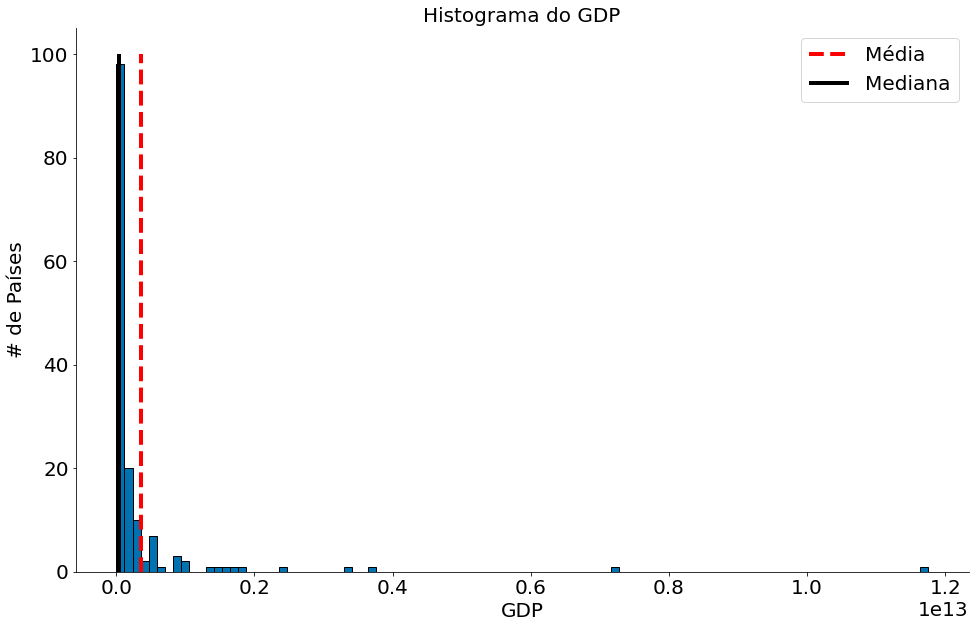

In [28]:
col = 'GDP'

x = df[col]

plt.hist(x, bins=100, edgecolor='k')
plt.vlines(x.mean(), 0, 100, label='Média', linestyles='--', edgecolor='k', color='red')
plt.vlines(x.median(), 0, 100, label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma do GDP')

plt.legend()

despine()

plt.show()

Outra forma de visualizar a maneira como essa distribuição é nada simétrica é através da CDF. Veja como 80% dos países tem o GDP baixo e muito próximo.

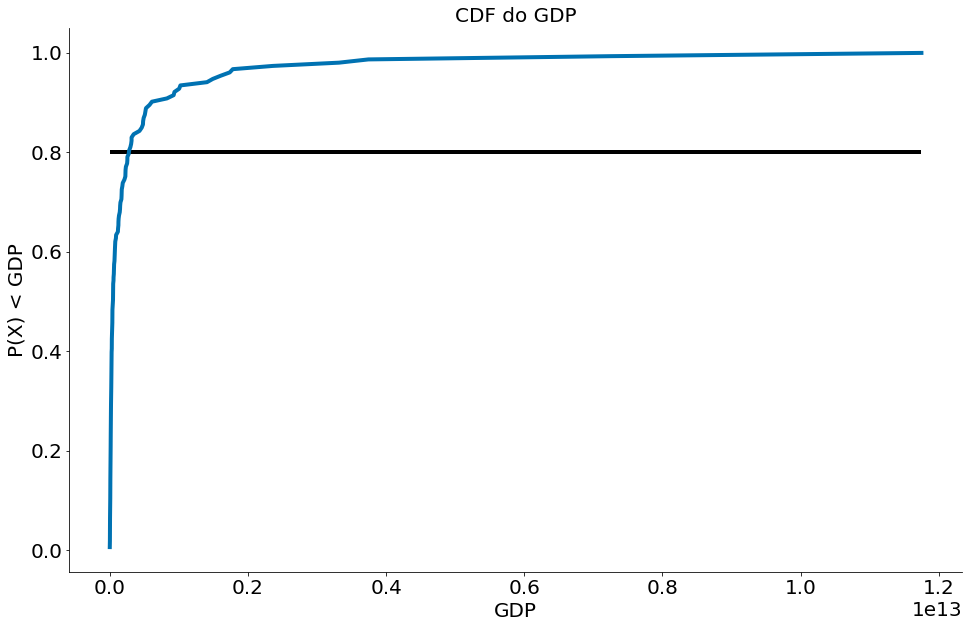

In [29]:
ecdf = ECDF(df[col])

plt.plot(ecdf.x, ecdf.y)
plt.hlines(0.8, df[col].min(), df[col].max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('P(X) < ' + col)
plt.title('CDF do GDP')

despine()

plt.show()

Aqui temos os 15 países com o maior GDP.

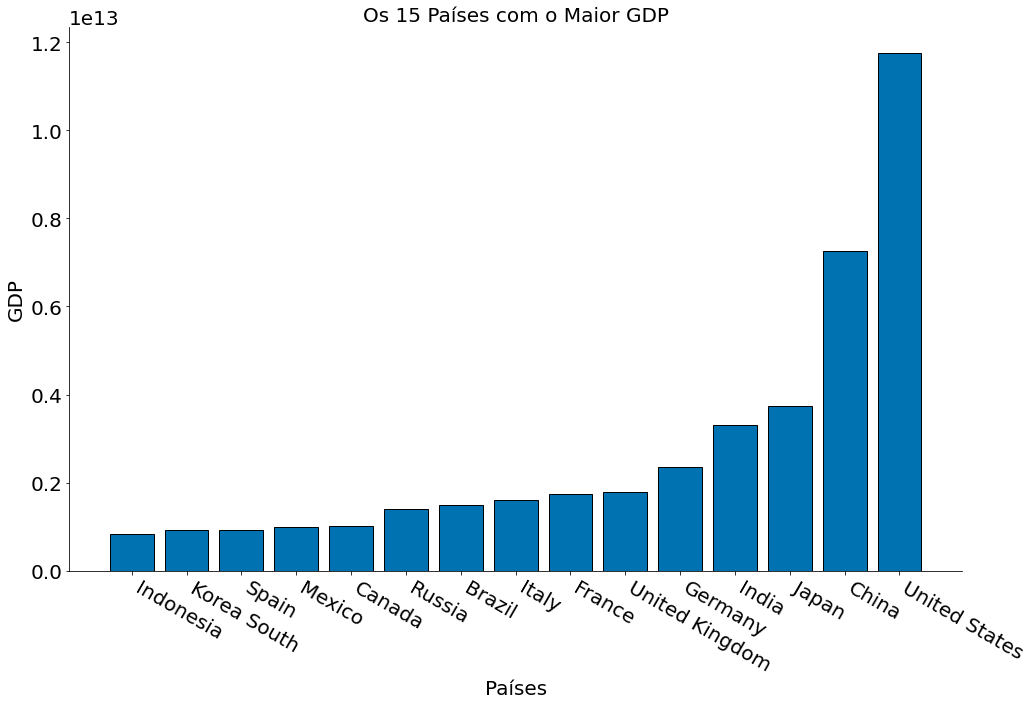

In [30]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][-15:]
y = dfsorted[col][-15:]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com o Maior GDP')

despine()

plt.show()

Agora, dos países mais pobres, veja como quase todos são da África e alguns da Ásia.

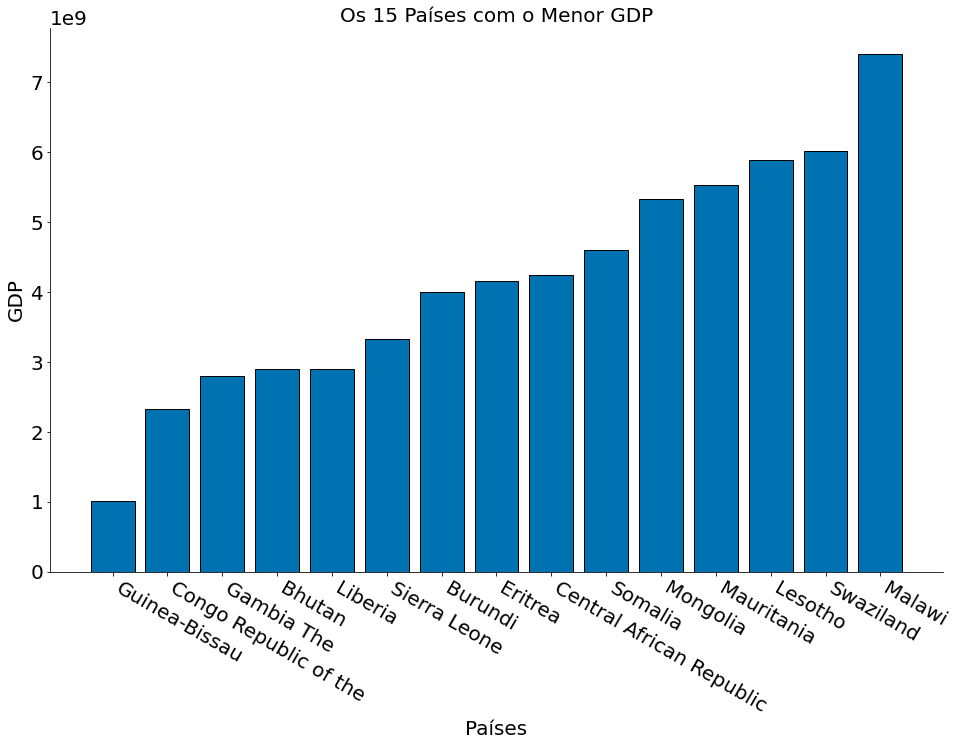

In [31]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][:15]
y = dfsorted[col][:15]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com o Menor GDP')

despine()

plt.show()

### 2. Visualização da Expectativa de Vida <a name="visuvida"></a>

Da mesma maneira que o GDP, a distribuição da Expectativa de Vida não é simétrica, entretanto, a intensidade dessa assimetria é bem menor. Além do que, nesse caso, existem muitos países com a Expectativa de Vida parecida e relativamente alta, ao invés do contrário.

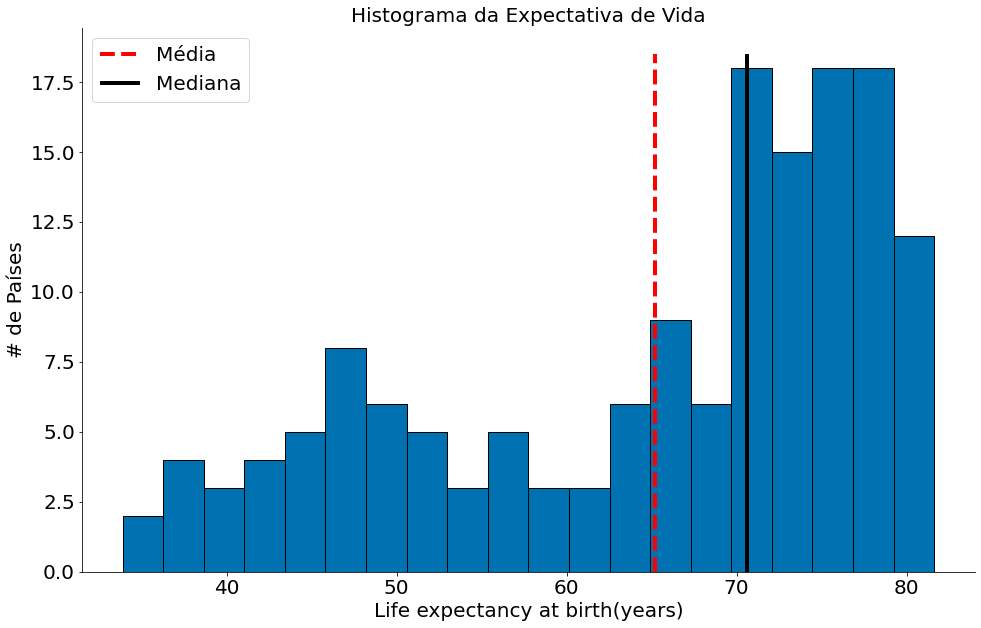

In [32]:
col = 'Life expectancy at birth(years)'
x = df[col]

plt.hist(x, bins=20, edgecolor='k')
plt.vlines(x.mean(), 0, 18.5, label='Média', linestyles='--', color='red')
plt.vlines(x.median(), 0, 18.5, label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O describe() não foi usado para o GDP porque os números são muito grandes e isso dificulta a leitura, entretando, é uma boa maneira de ter uma ideia rápida da distribuição da Expectativa de Vida.

In [33]:
df[col].describe()

count    153.000000
mean      65.206405
std       13.140678
min       33.870000
25%       55.080000
50%       70.610000
75%       75.910000
max       81.620000
Name: Life expectancy at birth(years), dtype: float64

Novamente, a CDF ajuda a ilustrar como a Expectativa de Vida é diferente do GDP.

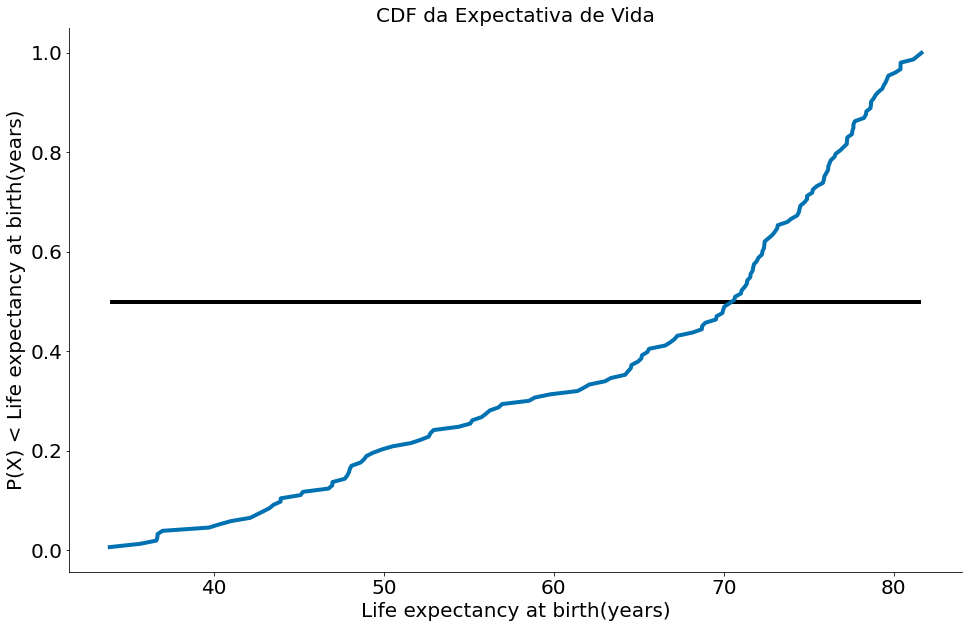

In [34]:
ecdf = ECDF(df[col])

plt.plot(ecdf.x, ecdf.y)
plt.hlines(0.5, df[col].min(), df[col].max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('P(X) < ' + col)
plt.title('CDF da Expectativa de Vida')

despine()

plt.show()

Veja que dos 15 países com maior Expectativa de  Vida, todos (com exceção talvez da Grécia) são considerados desenvolvidos. Deve existir alguma correlação. Não definimos o que é ser um país desenvolvido, essa é apenas uma observação.

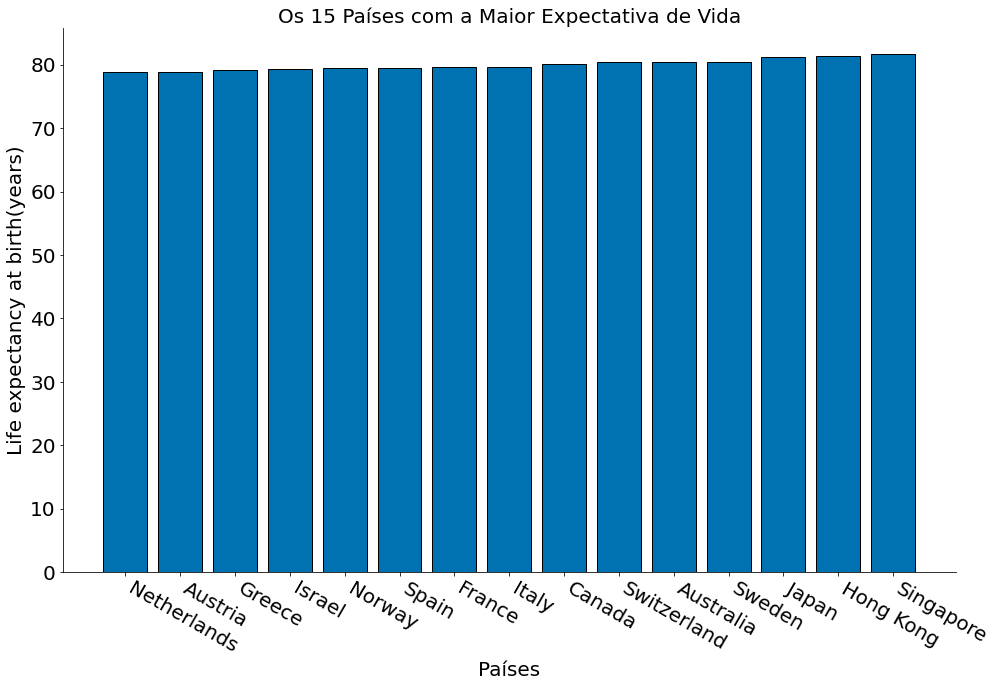

In [35]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][-15:]
y = dfsorted[col][-15:]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Maior Expectativa de Vida')

despine()

plt.show()

O gráfico a seguir mostra um sintoma de inúmeros problemas e um cenário extremamente triste. Vários países da África têm Expectativa de Vida a níveis da Idade Média, muito também pela enorme prevalência de doenças bastante mortais, péssimas condições de sáude além de outros fatores socio-econômicos.

Um comentário adicional vai para o Afeganistão, que desde bem recentemente se encontra dominado por um grupo terrorista.

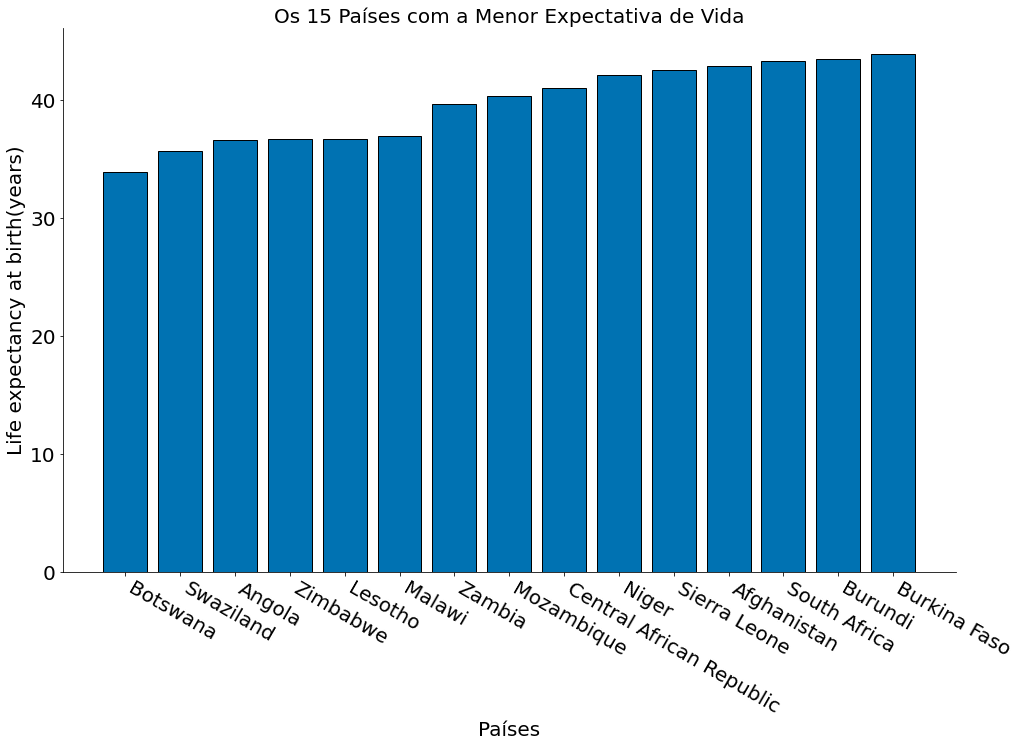

In [36]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][:15]
y = dfsorted[col][:15]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Menor Expectativa de Vida')

despine()

plt.show()

### 3. Visualização Extra <a name="visuextra"></a>

Por fim, iremos observar a Taxa de Desemprego, a Prevalência do HIV na população adulta e a Taxa de Inflação. Essa seção mostra os mesmos gráficos do GDP e da Expectativa de Vida, portanto, considere que são, de certa maneira, opcionais.


#### 1. Visualização da Taxa de Desemprego <a name="visudes"></a>

A Taxa de Desemprego é muito diferente dos dois casos anteriores, veja como poucos países possuem uma taxa altíssima, enquanto o resto segue uma distribuição parecida com a da Expectativa de Vida invertida.

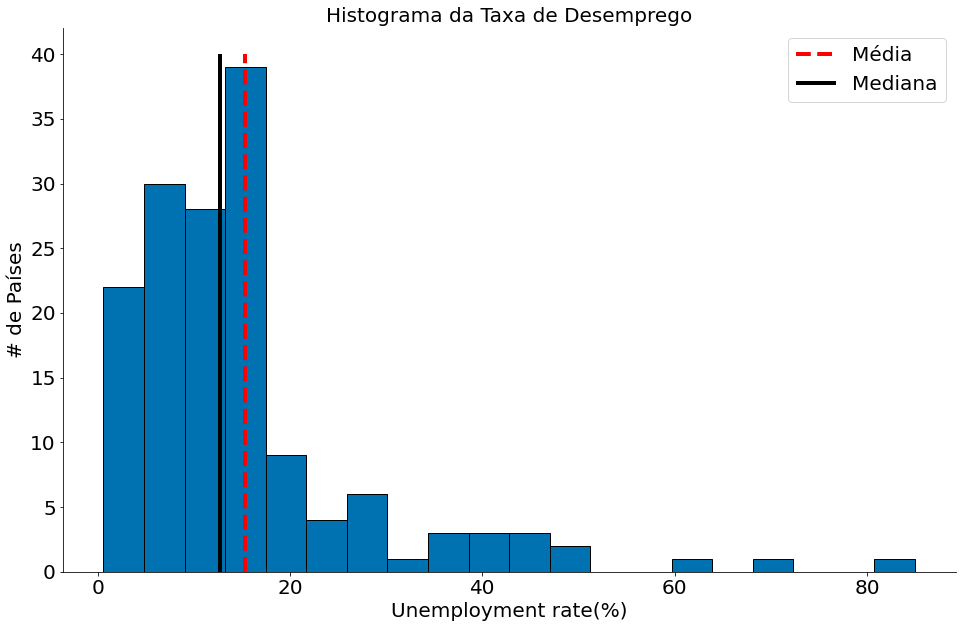

In [37]:
col = 'Unemployment rate(%)'
x = df[col]

plt.hist(x, bins=20, edgecolor='k')
plt.vlines(x.mean(), 0, 40, label='Média', linestyles='--', color='red')
plt.vlines(x.median(), 0, 40, label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma da Taxa de Desemprego')

plt.legend()

despine()

plt.show()

Novamente, uns países com taxa próxima de 0%, outros com mais do que 50%. Veja também como 75% dos dados estão abaixo de 15%.

In [38]:
df[col].describe()

count    153.000000
mean      15.292063
std       13.078813
min        0.600000
25%        7.000000
50%       12.700000
75%       15.292063
max       85.000000
Name: Unemployment rate(%), dtype: float64

A CDF é boa para mostrar o efeito de substituir os NaNs pela média da coluna, veja como acima da linha horizontal há uma subida totalmente vertical. De resto, a CDF mostra o que esperávamos. Uma subida brusca abaixo da média, enquanto acima dela há um aumento mais lento.

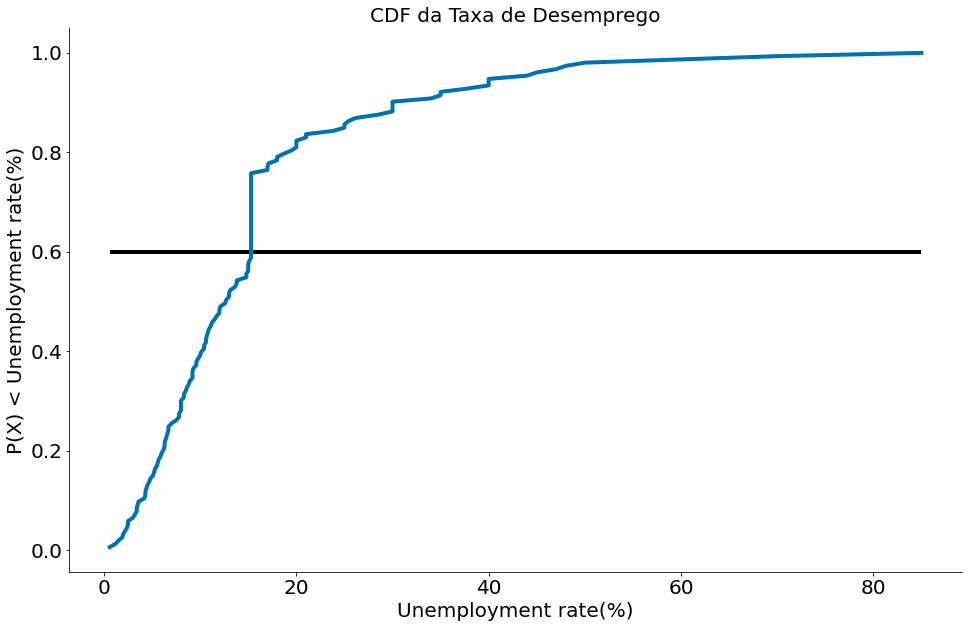

In [39]:
ecdf = ECDF(df[col])

plt.plot(ecdf.x, ecdf.y)
plt.hlines(0.6, df[col].min(), df[col].max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('P(X) < ' + col)
plt.title('CDF da Taxa de Desemprego')

despine()

plt.show()

Agora temos uma surpresa, no grupo dos 15 países com a maior Taxa de Desemprego temos um país europeu. É do Leste Europeu, que é, geralmente, menos desenvolvido, mas ainda assim. De resto, esse é um gráfico ligeiramente mais heterogêneo a nível de continentes.

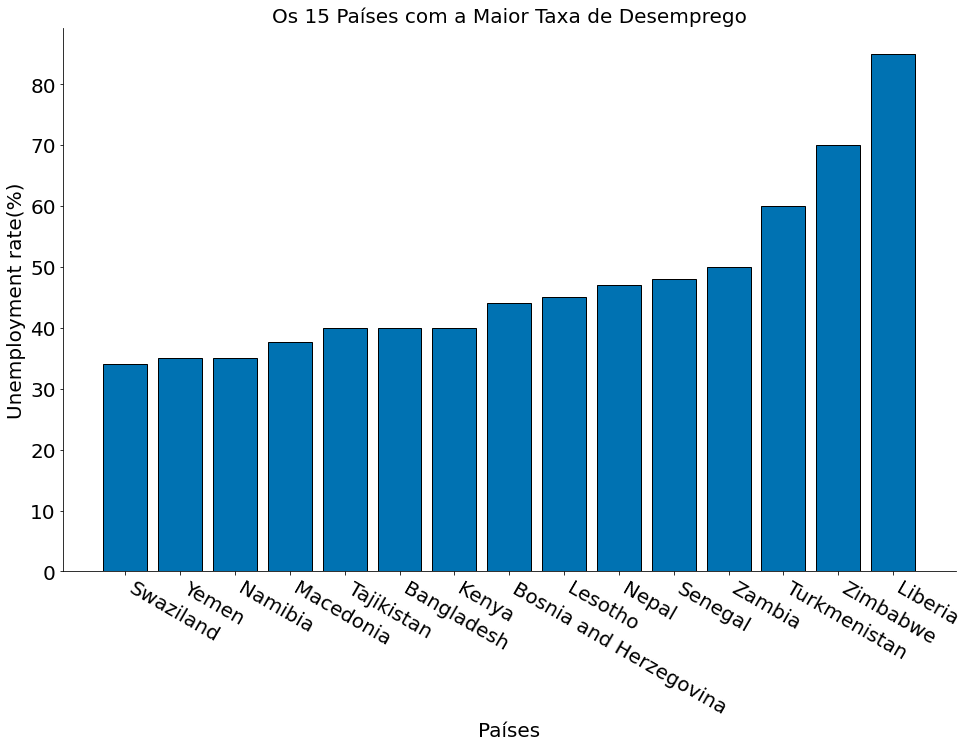

In [40]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][-15:]
y = dfsorted[col][-15:]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Maior Taxa de Desemprego')

despine()

plt.show()

A seguir o gráfico mais heterogêneo até então. Países de vários continentes e com várias características diferentes. Temos também algumas surpresas, como Uzbequistão como o país com a menor Taxa de Desemprego, além de países que não são considerados desenvolvidos.

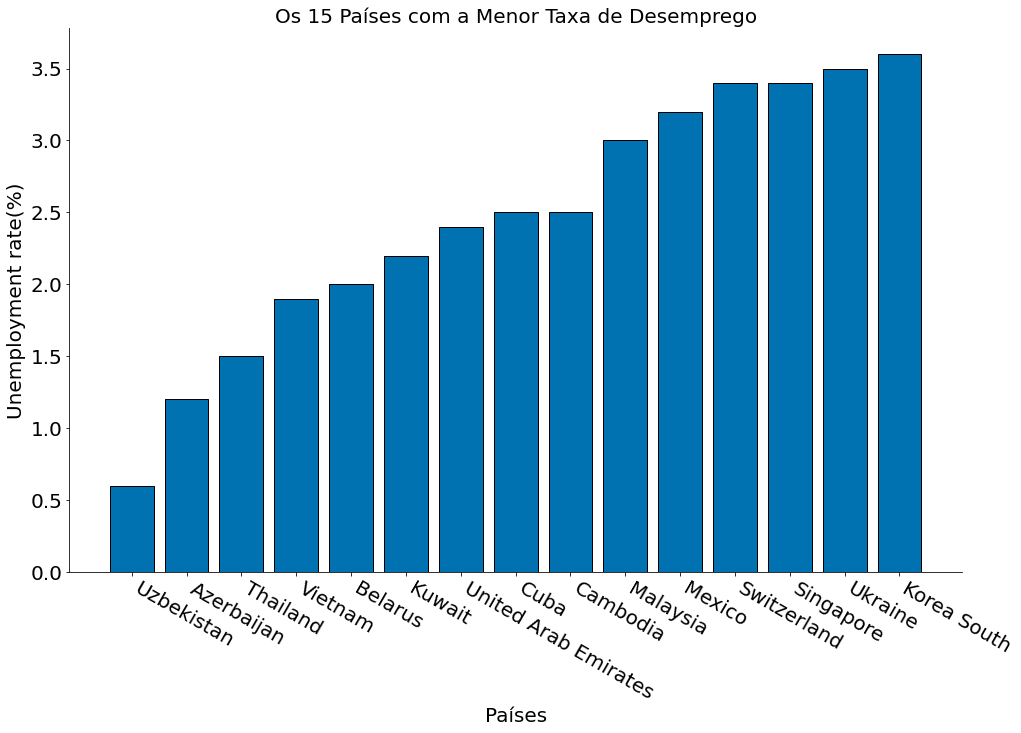

In [41]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][:15]
y = dfsorted[col][:15]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Menor Taxa de Desemprego')

despine()

plt.show()

#### 2. Visualização da Prevalência do HIV <a name="visuhiv"></a>

Finalmente, uma notícia boa. A grande maioria dos países tem baixa Prevalência do HIV em sua população adulta, entretanto, alguns países não souberam conter o espalhamento do vírus, infelizmente.

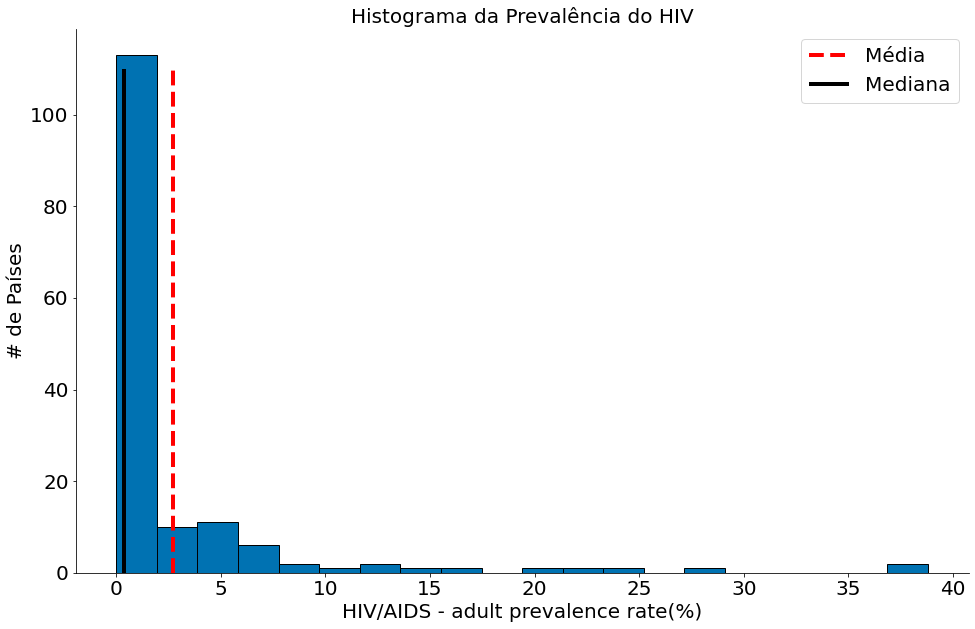

In [42]:
col = 'HIV/AIDS - adult prevalence rate(%)'
x = df[col]

plt.hist(x, bins=20, edgecolor='k')
plt.vlines(x.mean(), 0, 110, label='Média', linestyles='--', color='red')
plt.vlines(x.median(), 0, 110, label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma da Prevalência do HIV')

plt.legend()

despine()

plt.show()

Reiterando o fato de que poucos países perderam o controle do HIV.

In [43]:
df[col].describe()

count    153.000000
mean       2.737047
std        6.163333
min        0.010000
25%        0.100000
50%        0.400000
75%        2.600000
max       38.800000
Name: HIV/AIDS - adult prevalence rate(%), dtype: float64

A CDF mostra isso de mais uma maneira.

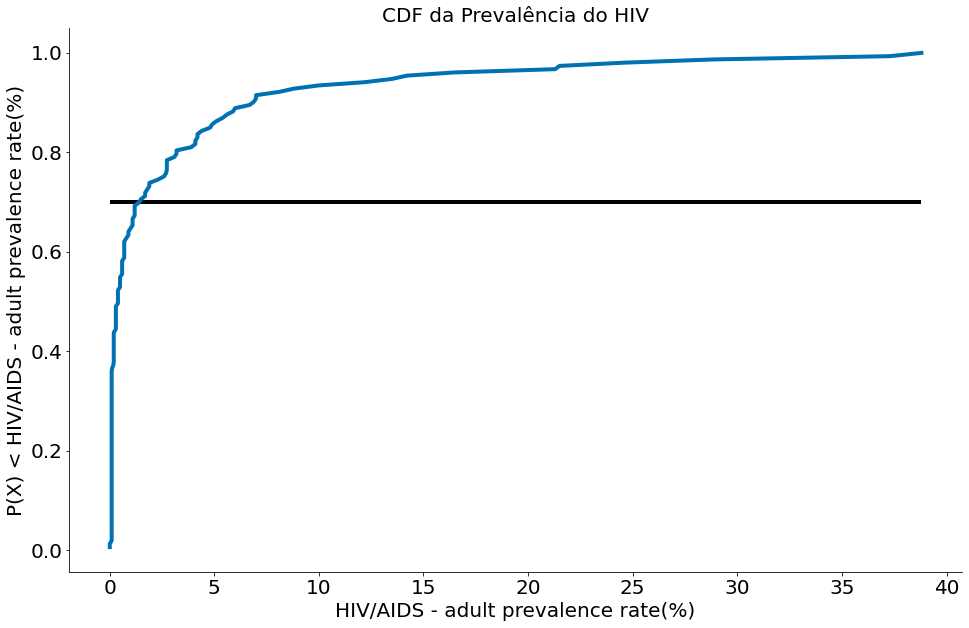

In [44]:
ecdf = ECDF(df[col])

plt.plot(ecdf.x, ecdf.y)
plt.hlines(0.7, df[col].min(), df[col].max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('P(X) < ' + col)
plt.title('CDF da Prevalência do HIV')

despine()

plt.show()

De novo, os países que perderam o controle do HIV estão concentrados na África.

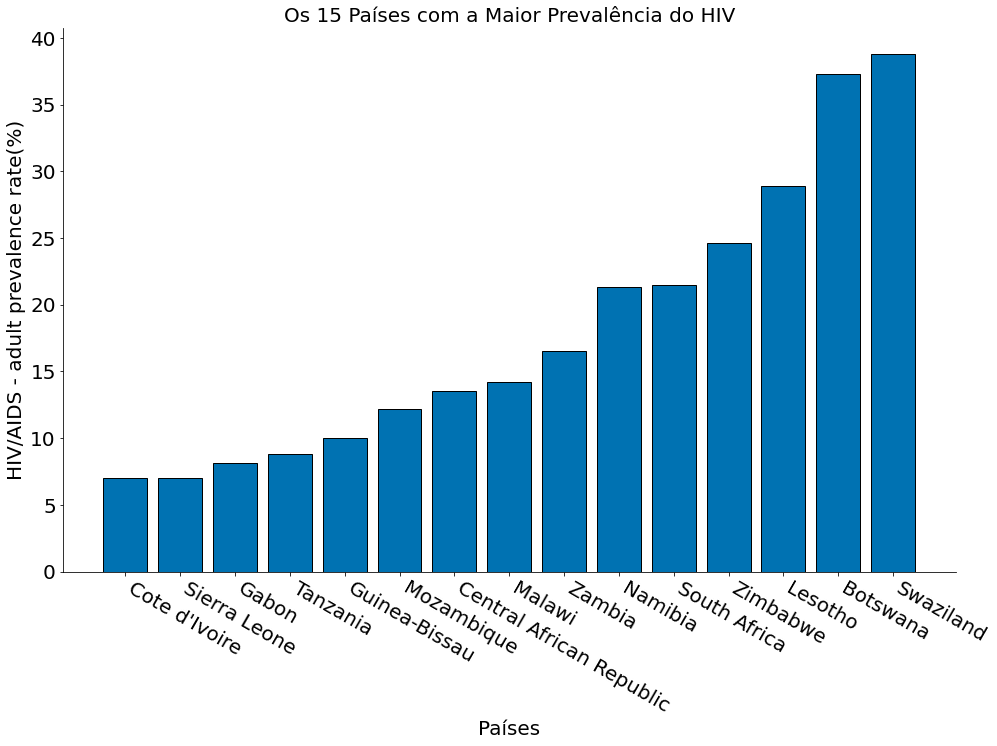

In [45]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][-15:]
y = dfsorted[col][-15:]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Maior Prevalência do HIV')

despine()

plt.show()

Ao contrário do mesmo gráfico para o caso da Taxa de Desemprego, aqui temos um gráfico mais homogêneo. Mas a surpresa está no fato de que ao contrário dos países da África apresentaram uma possível relação entre alta taxa de HIV e baixa Expectativa de Vida, o Afeganistão não mostra isso.

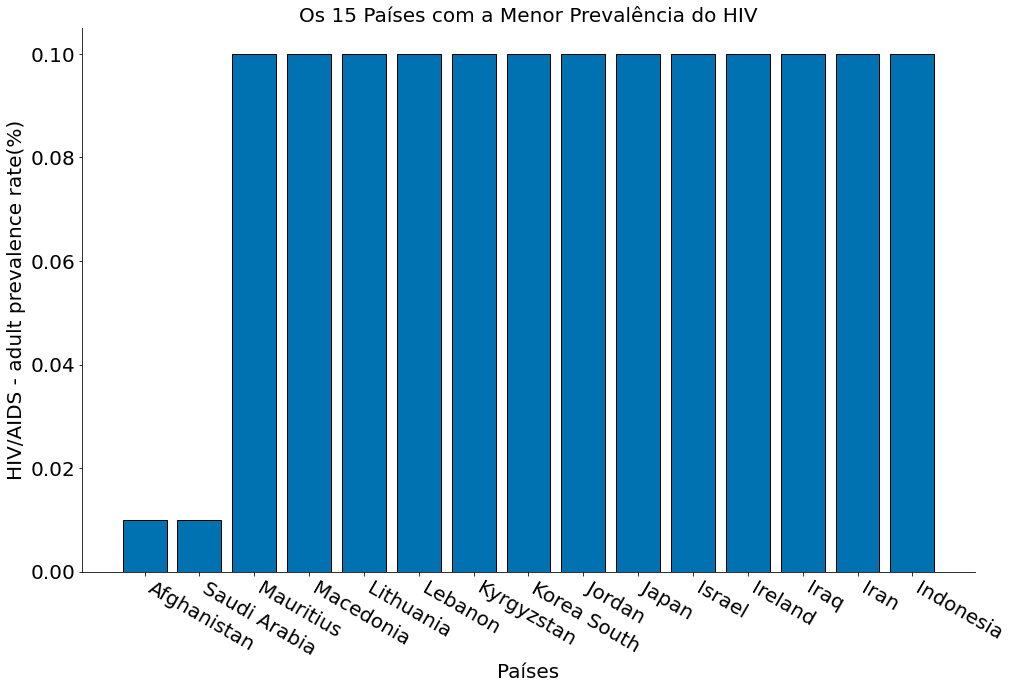

In [46]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][:15]
y = dfsorted[col][:15]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Menor Prevalência do HIV')

despine()

plt.show()

#### 3. Visualização da Taxa de Inflação <a name="visuinf"></a>

Aqui temos um caso parecido com o do HIV.

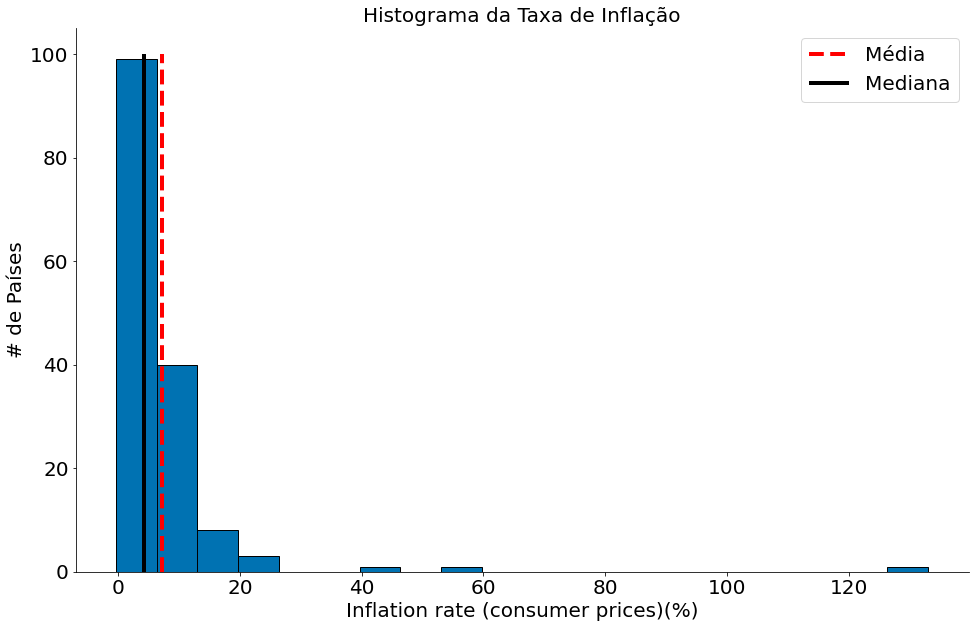

In [47]:
col = 'Inflation rate (consumer prices)(%)'
x = df[col]

plt.hist(x, bins=20, edgecolor='k')
plt.vlines(x.mean(), 0, 100, label='Média', linestyles='--', color='red')
plt.vlines(x.median(), 0, 100, label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma da Taxa de Inflação')

plt.legend()

despine()

plt.show()

O describe() mostra a semelhança com o caso do HIV de novo.

In [48]:
df[col].describe()

count    153.000000
mean       7.126490
std       12.387582
min       -0.300000
25%        2.300000
50%        4.200000
75%        8.000000
max      133.000000
Name: Inflation rate (consumer prices)(%), dtype: float64

Pela CDF podemos ver que talvez esse caso seja ainda mais extremo, em que pouquíssimos países tenham uma Taxa de Inflação fora de controle.

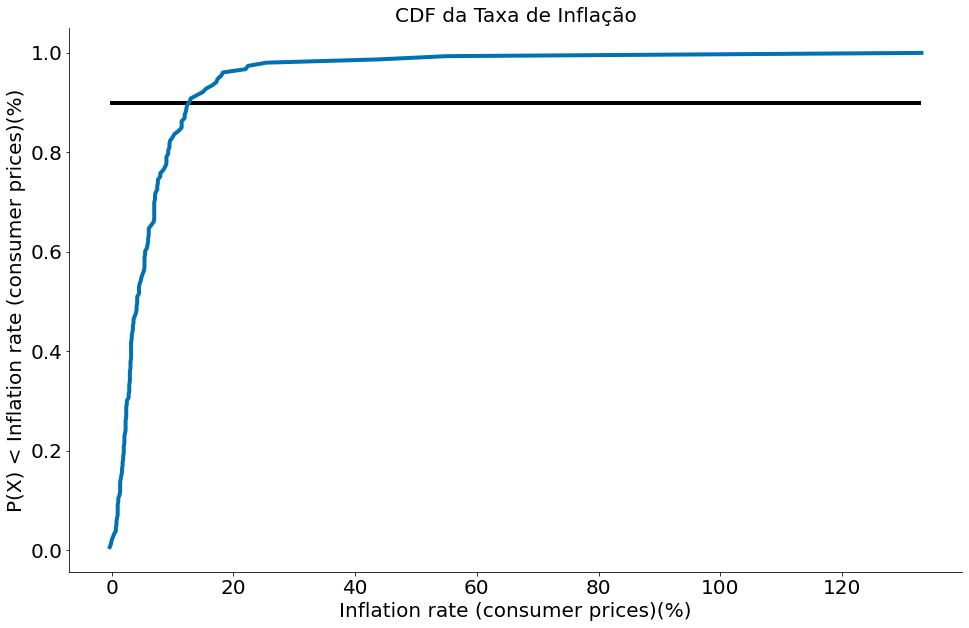

In [49]:
ecdf = ECDF(df[col])

plt.plot(ecdf.x, ecdf.y)
plt.hlines(0.9, df[col].min(), df[col].max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('P(X) < ' + col)
plt.title('CDF da Taxa de Inflação')

despine()

plt.show()

Observação especial para o caso icônico do Zimbabwe, que alcançou níveis astronômicos de inflação e possuía cédulas na casa dos trilhões.

Chamamos a atenção para que o leitor não se deixe levar pela perda de escala causada pela presença do Zimbabwe, uma Taxa de Inflação de 20% ainda é muito grande.

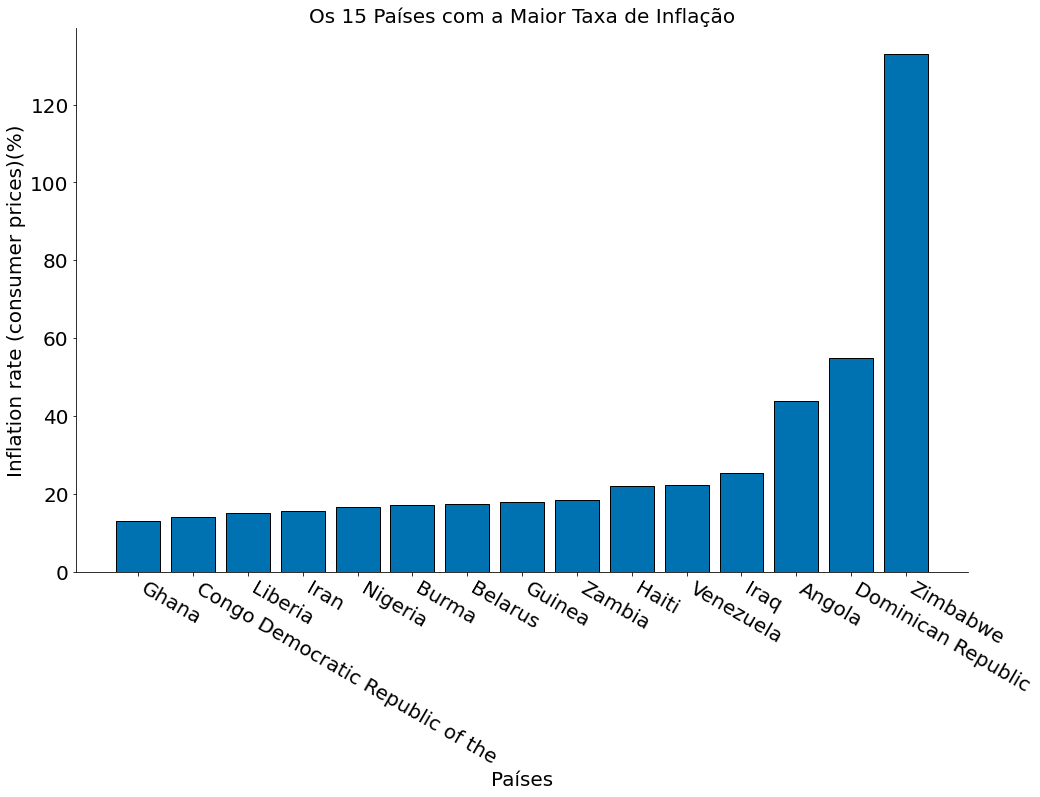

In [50]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][-15:]
y = dfsorted[col][-15:]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Maior Taxa de Inflação')

despine()

plt.show()

Talvez o gráfico mais surpreendente até agora. Primeiramente, casos de inflação zero ou deflação (inflação negativa). Segundo, vários países extremamente pobres da África presentes. Terceiro, a Bósnia e Herzegovina que estavam presentes no gráfico dos países com a maior Taxa de Desemprego, deve haver alguma coisa em jogo para explicar essa inflação tão baixa. Especialmente pelo fato de o Zimbabwe também estar presente no gráfico dos países com a maior Taxa de Desemprego e ser o que tem a maior Taxa de Inflação.

Por fim, a parte não surpreendente é que alguns dos países considerados como "paraíso" estão presentes, são eles a Finlândia, a Suécia, a Suíça e a Noruega.

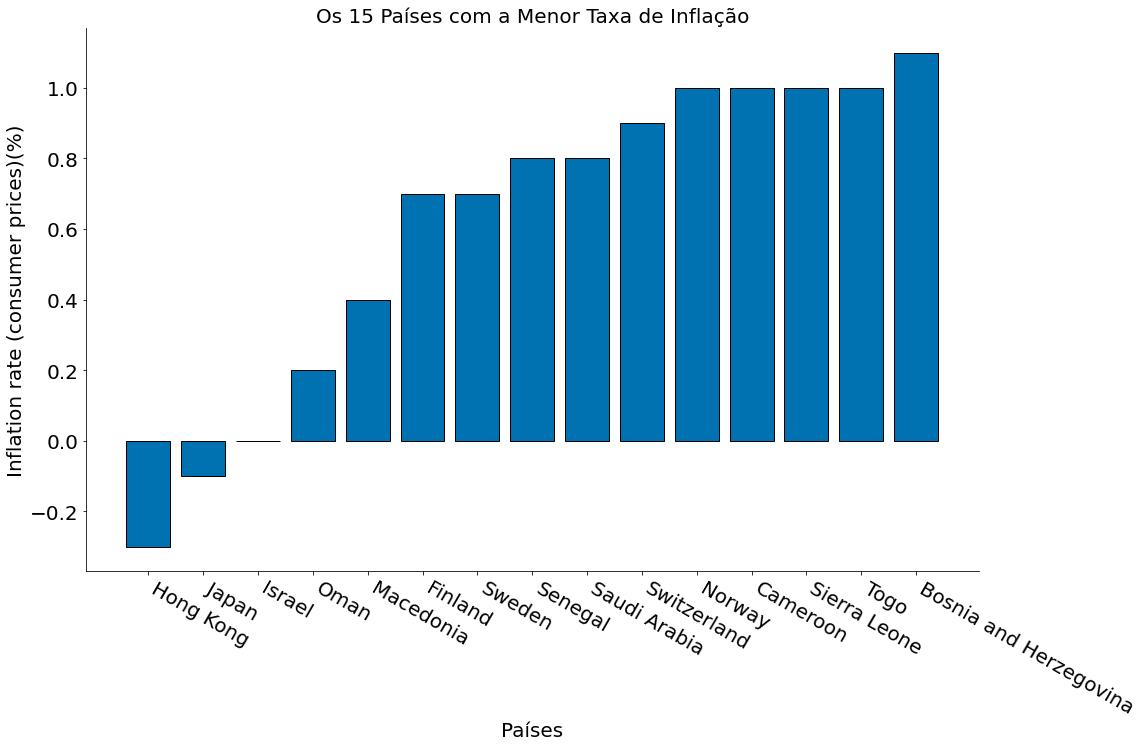

In [51]:
dfsorted = df.copy()
dfsorted = dfsorted.sort_values(by=col)

x = dfsorted['Country'][:15]
y = dfsorted[col][:15]

plt.bar(x, y, edgecolor='k')
plt.xticks(rotation = -30, ha='left')
plt.xlabel('Países')
plt.ylabel(col)
plt.title('Os 15 Países com a Menor Taxa de Inflação')

despine()

plt.show()

## 5. Testes de Hipóteses <a name="testes"></a>

### 1. Testes da Expectativa de Vida <a name="testevida"></a>

Aqui faremos o bootstrap e calcularemos intervalos de confiança para mostrar uma possível correlação entre Expectativa de Vida e GDP.

Para isso, criaremos duas "classes", os países que possuem a Expectativa de Vida acima da média e aqueles que a possuem abaixo da média. Iremos ignorar a média já que a usamos para preencher os NaNs.

Como o leitor pode acompanhar, os ICs não se cruzam, o que significa, que, estatisticamente falando, o acaso não é capaz de explicar essa diferença.

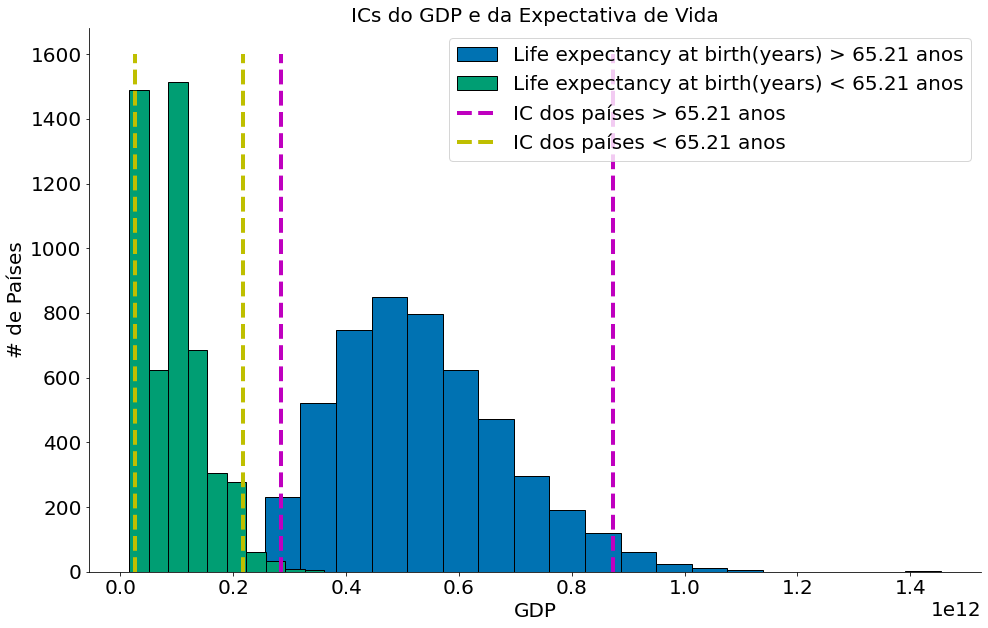

In [52]:
col = 'Life expectancy at birth(years)'
corte = df[col].mean()

filtro = df[col] > corte
df1 = df['GDP'][filtro]

filtro = df[col] < corte
df2 = df['GDP'][filtro]

df1_mean = bootstrap_mean(df1)
df2_mean = bootstrap_mean(df2)

text = str(round(corte, ndigits=2))

LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)
LI2 = np.percentile(df2_mean, 2.5)
LS2 = np.percentile(df2_mean, 97.5)

ymin = 0
ymax = 1600

plt.hist(df1_mean, bins=20, edgecolor='k', label=col + ' > ' + text + ' anos')
plt.hist(df2_mean, bins=10, edgecolor='k', label=col + ' < ' + text + ' anos')
plt.vlines(LI1, ymin, ymax, linestyles='--', label='IC dos países' + ' > ' + text + ' anos', color='m')
plt.vlines(LS1, ymin, ymax, linestyles='--', edgecolor='m')
plt.vlines(LI2, ymin, ymax, linestyles='--', label='IC dos países' + ' < ' + text + ' anos', color='y')
plt.vlines(LS2, ymin, ymax, linestyles='--', edgecolor='y')
plt.xlabel('GDP')
plt.ylabel('# de Países')
plt.title('ICs do GDP e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

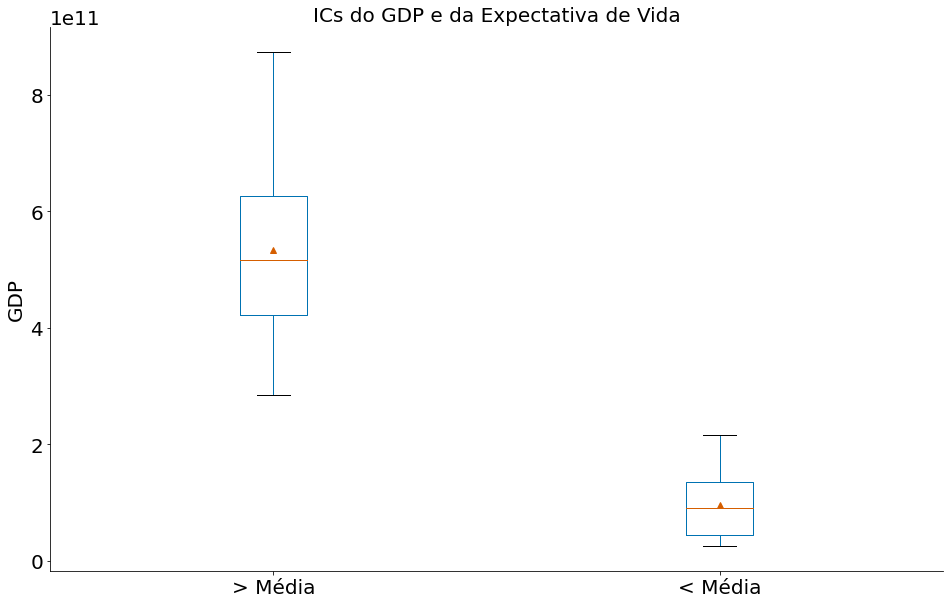

In [53]:
df3 = pd.DataFrame()

df3['> Média'] = df1_mean
df3['< Média'] = df2_mean

df3.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

### 2. Teste da Taxa de Desemprego <a name="testedes"></a>

Fizemos o mesmo que na sub-seção anterior, veja, novamente, que os ICs não se sobrepõem. Entretanto, agora a diferença parece ser maior, a Taxa de Desemprego parece ter uma influência maior no GDP de um país, especialmente quando essa taxa é alta.

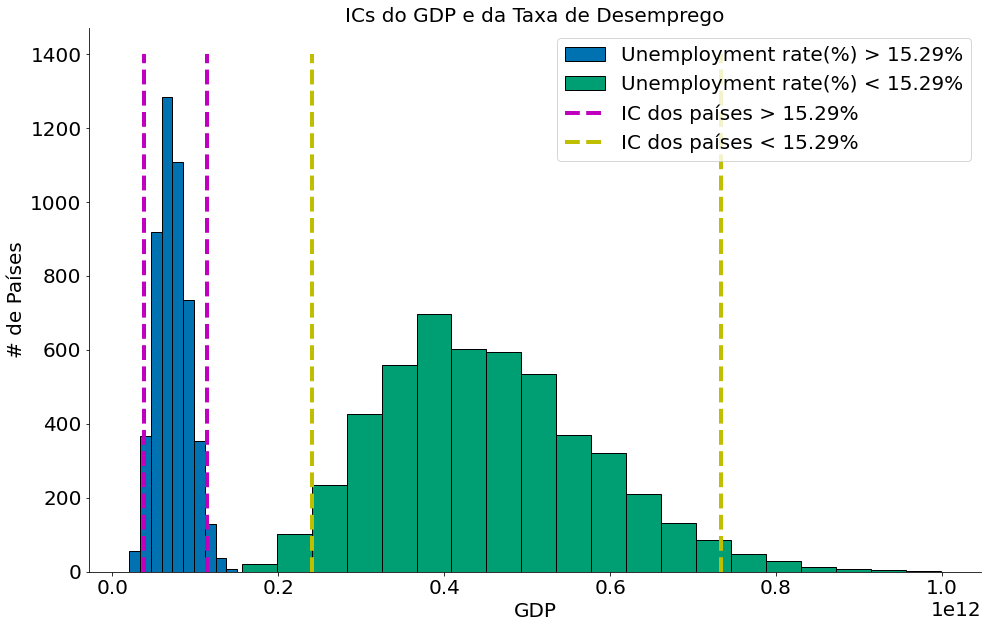

In [54]:
col = 'Unemployment rate(%)'
corte = df[col].mean()

filtro = df[col] > corte
df1 = df['GDP'][filtro]

filtro = df[col] < corte
df2 = df['GDP'][filtro]

df1_mean = bootstrap_mean(df1)
df2_mean = bootstrap_mean(df2)

text = str(round(corte, ndigits=2))

LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)
LI2 = np.percentile(df2_mean, 2.5)
LS2 = np.percentile(df2_mean, 97.5)

ymin = 0
ymax = 1400

plt.hist(df1_mean, bins=10, edgecolor='k', label=col + ' > ' + text + '%')
plt.hist(df2_mean, bins=20, edgecolor='k', label=col + ' < ' + text + '%')
plt.vlines(LI1, ymin, ymax, linestyles='--', label='IC dos países' + ' > ' + text + '%', color='m')
plt.vlines(LS1, ymin, ymax, linestyles='--', edgecolor='m')
plt.vlines(LI2, ymin, ymax, linestyles='--', label='IC dos países' + ' < ' + text + '%', color='y')
plt.vlines(LS2, ymin, ymax, linestyles='--', edgecolor='y')
plt.xlabel('GDP')
plt.ylabel('# de Países')
plt.title('ICs do GDP e da Taxa de Desemprego')

plt.legend()

despine()

plt.show()

O BoxPlot mostra como essa influência é mais acentuada nos casos de alta Taxa de Desemprego.

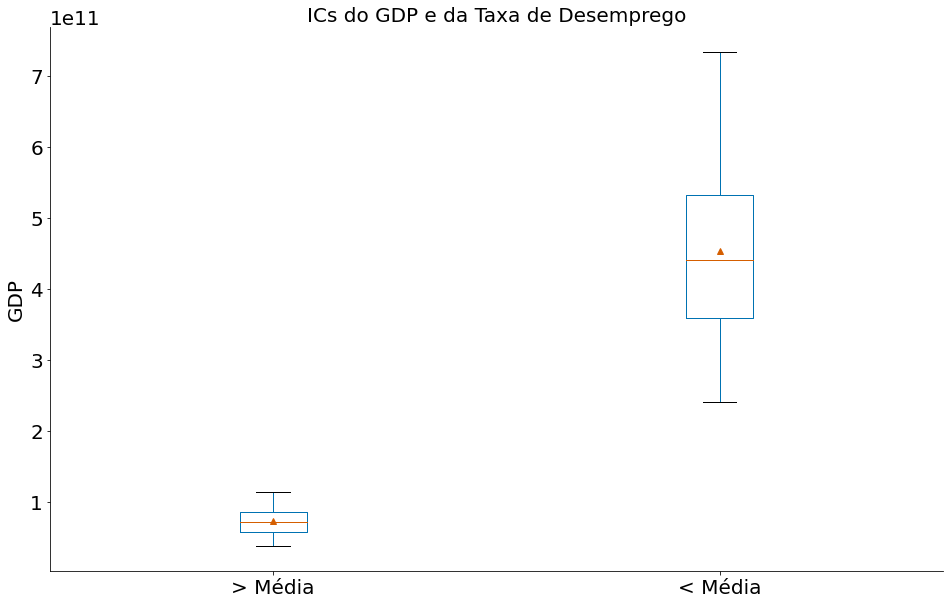

In [55]:
df3 = pd.DataFrame()

df3['> Média'] = df1_mean
df3['< Média'] = df2_mean

df3.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Taxa de Desemprego')

despine()

plt.show()

### 3. Teste da Prevalência do HIV <a name="testehiv"></a>

O caso da Taxa de Desemprego se repete. Certamente, uma população que morre cedo, gasta mais recursos públicos com saúde e não podem exercer funções profissionais normalmente faz com que o GDP do seu país seja pequeno.

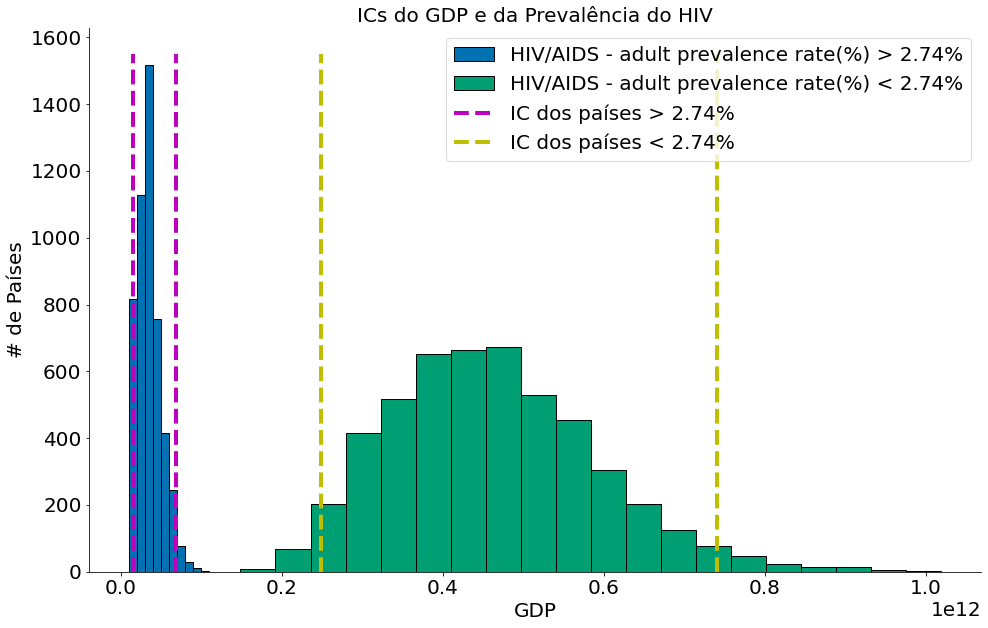

In [56]:
col = 'HIV/AIDS - adult prevalence rate(%)'
corte = df[col].mean()

filtro = df[col] > corte
df1 = df['GDP'][filtro]

filtro = df[col] < corte
df2 = df['GDP'][filtro]

df1_mean = bootstrap_mean(df1)
df2_mean = bootstrap_mean(df2)

text = str(round(corte, ndigits=2))

LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)
LI2 = np.percentile(df2_mean, 2.5)
LS2 = np.percentile(df2_mean, 97.5)

ymin = 0
ymax = 1550

plt.hist(df1_mean, bins=10, edgecolor='k', label=col + ' > ' + text + '%')
plt.hist(df2_mean, bins=20, edgecolor='k', label=col + ' < ' + text + '%')
plt.vlines(LI1, ymin, ymax, linestyles='--', label='IC dos países' + ' > ' + text + '%', color='m')
plt.vlines(LS1, ymin, ymax, linestyles='--', edgecolor='m')
plt.vlines(LI2, ymin, ymax, linestyles='--', label='IC dos países' + ' < ' + text + '%', color='y')
plt.vlines(LS2, ymin, ymax, linestyles='--', edgecolor='y')
plt.xlabel('GDP')
plt.ylabel('# de Países')
plt.title('ICs do GDP e da Prevalência do HIV')

plt.legend()

despine()

plt.show()

A influência de uma alta Prevalência do HIV no GDP é tão grande que o box da esquerda parece quase uma linha.

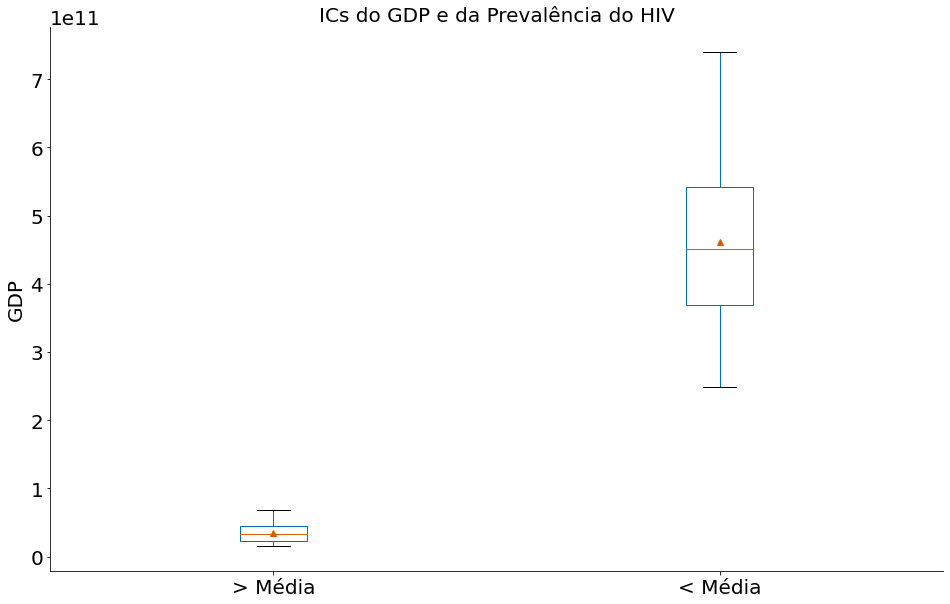

In [57]:
df3 = pd.DataFrame()

df3['> Média'] = df1_mean
df3['< Média'] = df2_mean

df3.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Prevalência do HIV')

despine()

plt.show()

### 4. Teste da Taxa de Inflação <a name="testeinf"></a>

Talvez surpreendentemente, a Taxa de Inflação não parece ter uma influência estatisticamente relevante no GDP, já que nesse caso os ICs se cruzam.

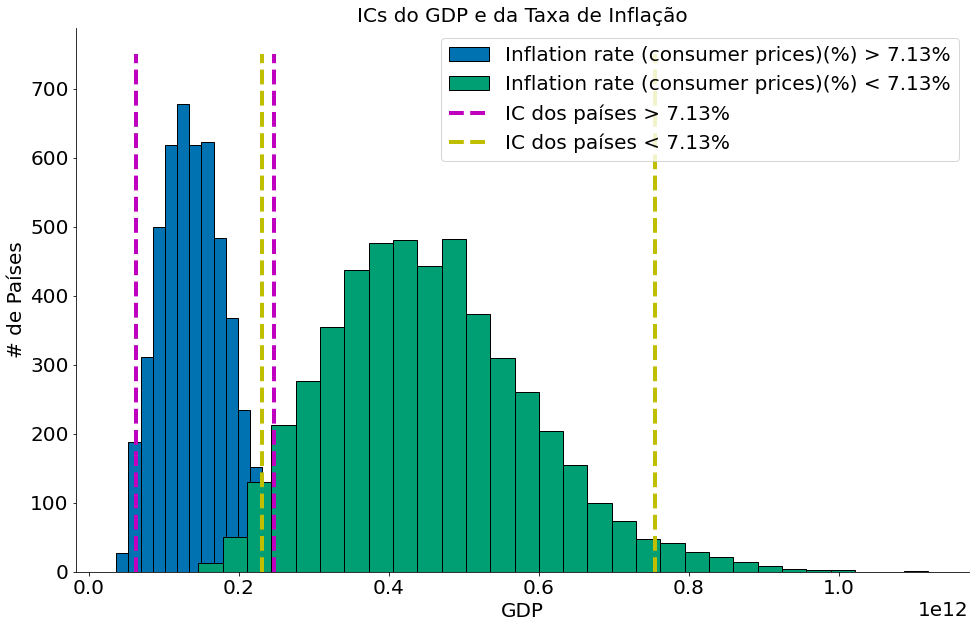

In [58]:
col = 'Inflation rate (consumer prices)(%)'
corte = df[col].mean()

filtro = df[col] > corte
df1 = df['GDP'][filtro]

filtro = df[col] < corte
df2 = df['GDP'][filtro]

df1_mean = bootstrap_mean(df1)
df2_mean = bootstrap_mean(df2)

text = str(round(corte, ndigits=2))

LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)
LI2 = np.percentile(df2_mean, 2.5)
LS2 = np.percentile(df2_mean, 97.5)

ymin = 0
ymax = 750

plt.hist(df1_mean, bins=20, edgecolor='k', label=col + ' > ' + text + '%')
plt.hist(df2_mean, bins=30, edgecolor='k', label=col + ' < ' + text + '%')
plt.vlines(LI1, ymin, ymax, linestyles='--', label='IC dos países' + ' > ' + text + '%', color='m')
plt.vlines(LS1, ymin, ymax, linestyles='--', edgecolor='m')
plt.vlines(LI2, ymin, ymax, linestyles='--', label='IC dos países' + ' < ' + text + '%', color='y')
plt.vlines(LS2, ymin, ymax, linestyles='--', edgecolor='y')
plt.xlabel('GDP')
plt.ylabel('# de Países')
plt.title('ICs do GDP e da Taxa de Inflação')

plt.legend()

despine()

plt.show()

O BoxPlot reitera o fato anterior. Veja como os whiskers das box se cruzam ligeiramente.

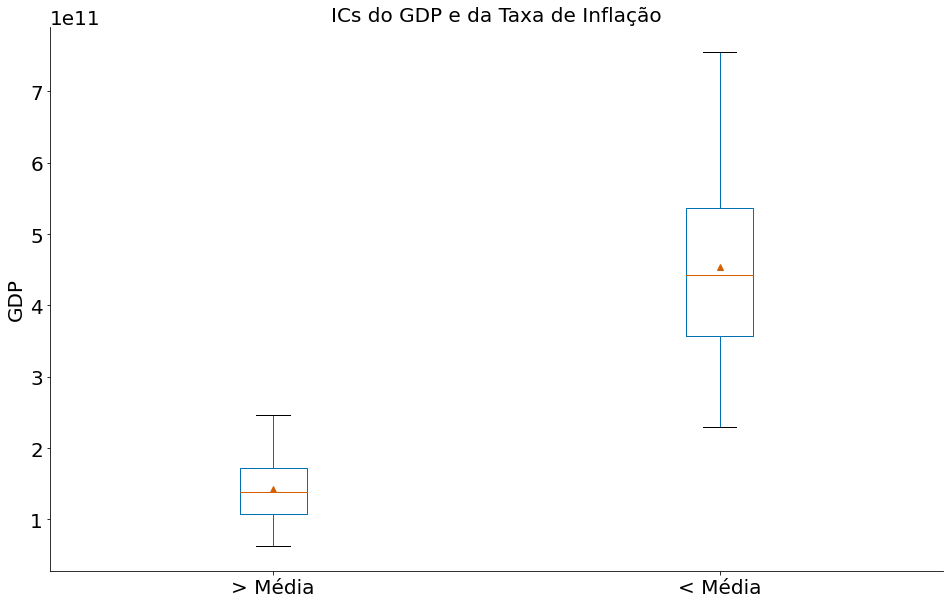

In [59]:
df3 = pd.DataFrame()

df3['> Média'] = df1_mean
df3['< Média'] = df2_mean

df3.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Taxa de Inflação')

despine()

plt.show()

### 5. Correlação entre Prevalência do HIV e Expectativa de Vida <a name="hivvida"></a>

Como esperado, parece existir uma correlação entre a Prevalência do HIV e a Expectativa de Vida de uma população. Esse dado é apenas uma curiosidade, já que estamos tentando ver quais fatores têm mais ou menos influência no GDP.

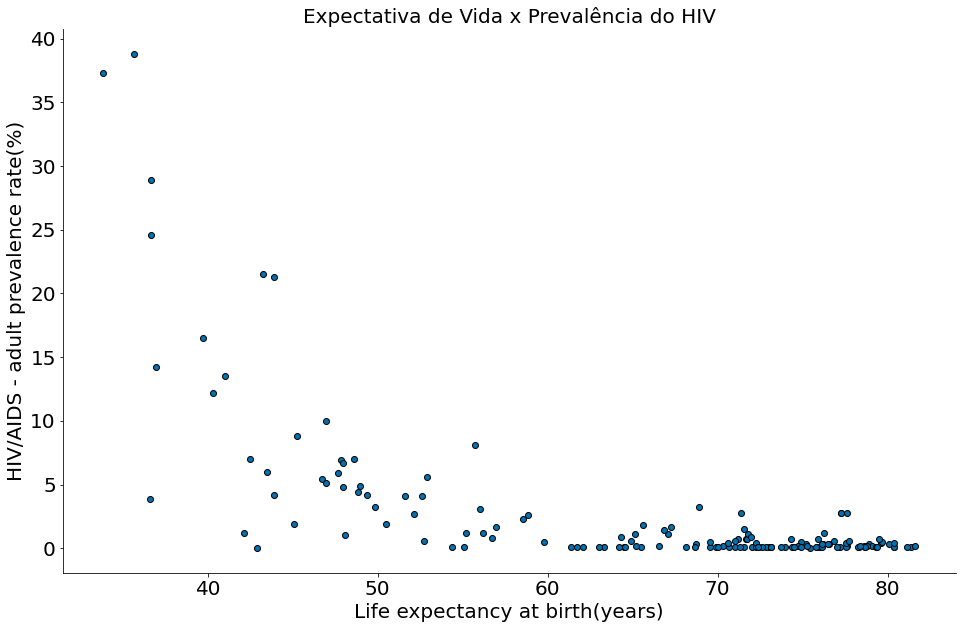

In [60]:
colx = 'Life expectancy at birth(years)'
coly = 'HIV/AIDS - adult prevalence rate(%)'

plt.scatter(df[colx], df[coly], edgecolors='k')
plt.xlabel(colx)
plt.ylabel(coly)
plt.title('Expectativa de Vida x Prevalência do HIV')

despine()

plt.show()

## 6. Separação dos Grupos <a name="grupos"></a>

Separamos os grupos de treino e teste. Escolhemos deixar as duas colunas que contém outras informações sobre o GDP porque uma delas é relativa (e também depende do tamanho da população) e a outra não diz nada sobre o valor absoluto do GDP (por mais que seja mais difícil um GDP já alto crescer).

In [81]:
X = df.copy()
X = X.drop(['GDP', 'Country'], axis=1)
y = df['GDP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Usamos o StandardScaler do SKLearn para Z-normalizar os dados de treino e teste.

In [82]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train[:,np.newaxis])

## 7. Fit dos Modelos <a name="fit"></a>

Usamos o SKLearn, de novo, para fazer a Regressão Linear Múltipla e mostramos os coeficientes para cada coluna do DataFrame de teste.



In [83]:
linear = LinearRegression(fit_intercept=False)
lasso = GridSearchCV(Lasso(fit_intercept=False), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
ridge = GridSearchCV(Ridge(fit_intercept=False), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})

Fazemos, então o fit de cada modelo e mostramos seu Coeficiente de Determinação.

In [84]:
linear = linear.fit(X_train, y_train)
linear.score(X_train, y_train)

0.9986576480910365

In [85]:
lasso = lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

0.9983890398428

Nos casos do Lasso, Ridge e KNN mostramos também os melhores hiper-parâmetros.

In [86]:
lasso.best_params_

{'alpha': 0.001}

In [87]:
ridge = ridge.fit(X_train, y_train)
ridge.score(X_train, y_train)

0.9968369517987171

In [88]:
ridge.best_params_

{'alpha': 10}

In [89]:
knn = knn.fit(X_train, y_train)
knn.score(X_train, y_train)

1.0

In [90]:
knn.best_params_

{'n_neighbors': 2, 'weights': 'distance'}

## 8. Avaliação dos Modelos <a name="aval"></a>

Para fazer a avaliação dos diferentes modelos usados nesse notebook, iremos utilizar o Erro Médio Quadrado. Quanto maior o erro, pior é o modelo, o ideal é um erro 0.

### 1. Visualização do MSE <a name="mse"></a>

#### 1. MSE da Regressão Linear <a name="msereglin"></a>

A seguir iremos visualizar o IC do MSE da Regressão Linear. Calculamos o IC usando bootstrap, novamente.

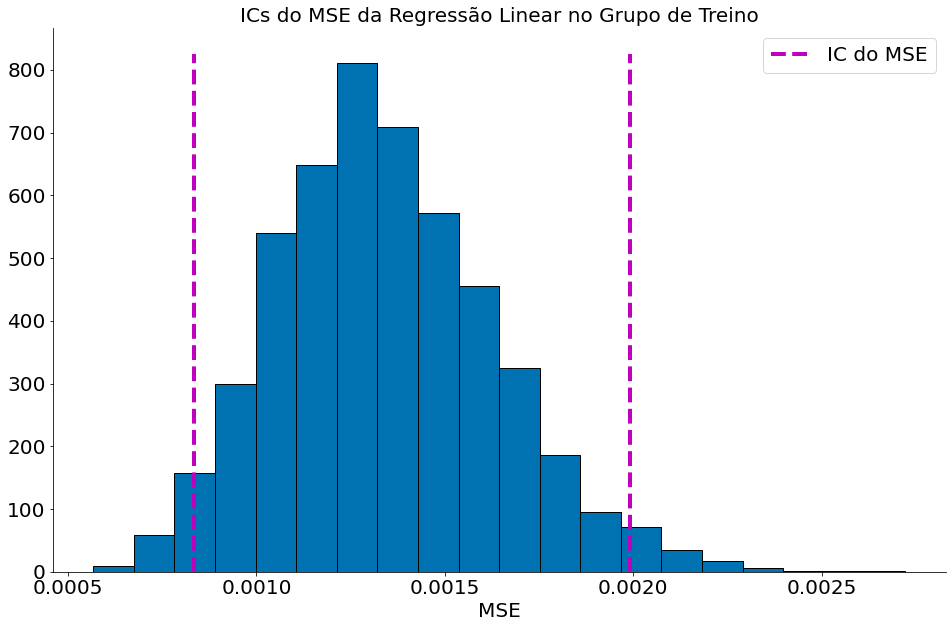

In [91]:
mse_values = bootstrap_mse(X_train, y_train, linear)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=20, edgecolor='k')
plt.vlines(LI, 0, 825, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, 0, 825, linestyles='--', color='m')
plt.xlabel('MSE')
plt.title('ICs do MSE da Regressão Linear no Grupo de Treino')

plt.legend()

despine()

plt.show()

#### 2. MSE do Lasso <a name="mselasso"></a>

IC do Lasso mostra uma pequena piora em relação à Regressão Linear.


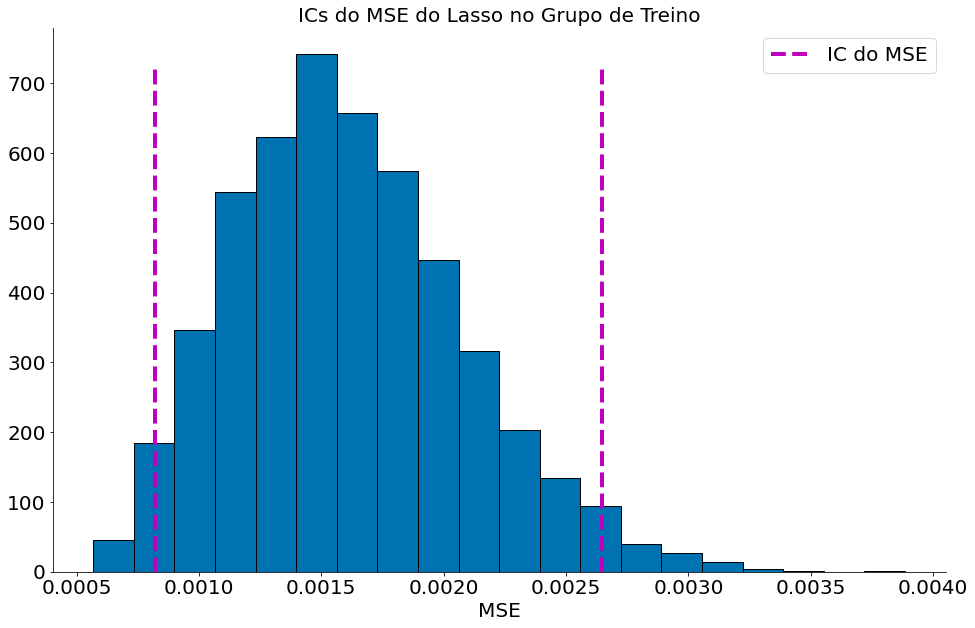

In [92]:
mse_values = bootstrap_mse(X_train, y_train, lasso)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=20, edgecolor='k')
plt.vlines(LI, 0, 725, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, 0, 725, linestyles='--', color='m')
plt.xlabel('MSE')
plt.title('ICs do MSE do Lasso no Grupo de Treino')

plt.legend()

despine()

plt.show()

#### 3. MSE do Ridge <a name="mseridge"></a>

O Ridge se parece muito com o Lasso.

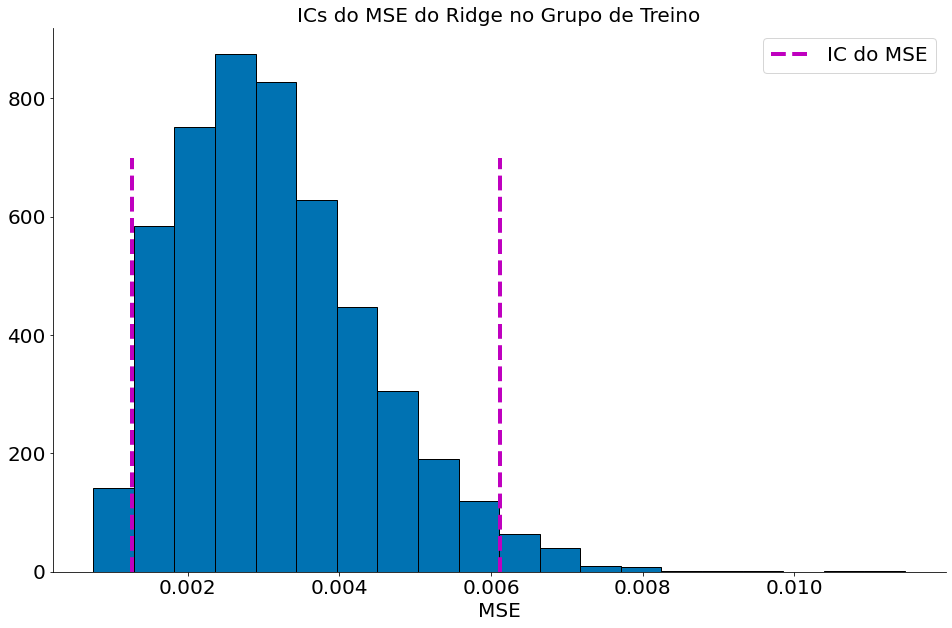

In [93]:
mse_values = bootstrap_mse(X_train, y_train, ridge)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=20, edgecolor='k')
plt.vlines(LI, 0, 700, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, 0, 700, linestyles='--', color='m')
plt.xlabel('MSE')
plt.title('ICs do MSE do Ridge no Grupo de Treino')

plt.legend()

despine()

plt.show()

#### 4. MSE do KNN <a name="mseknn"></a>

Já o KNN é perfeito, o que não é, necessariamente, um bom sinal. Ele pode estar fazendo overfitting, ou seja, decorando os dados do treino, ao invés de aprender.

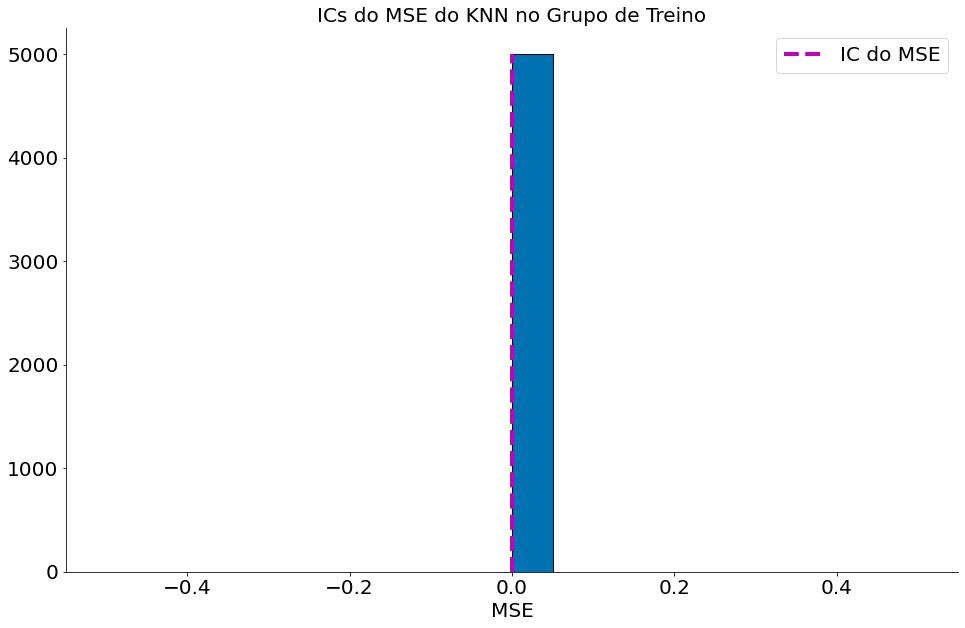

In [94]:
mse_values = bootstrap_mse(X_train, y_train, knn)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=20, edgecolor='k')
plt.vlines(LI, 0, 5000, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, 0, 5000, linestyles='--', color='m')
plt.xlabel('MSE')
plt.title('ICs do MSE do KNN no Grupo de Treino')

plt.legend()

despine()

plt.show()

### 2. Avaliação Usando o Grupo de Teste <a name="grupoteste"></a>

Agora uma avaliação com os dados do grupo de teste, simulando, assim, uma situação do mundo real, na qual não sabemos a resposta de antemão.

Primeiro Z-normalizamos os dados do teste com a média e o desvio padrão dos dados de treino, de forma a não utilizar nenhuma informação do treino, no teste.

In [95]:
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test[:,np.newaxis])

#### 1. Regressão Linear no Grupo de Teste <a name="reglinteste"></a>

Fazemos uma comparação do grupo de treino e o de teste, usando bootstrap.

Como esperado, o IC do grupo de teste é bem maior, e no caso da Regressão Linear, a performance não foi tão boa no grupo de teste.

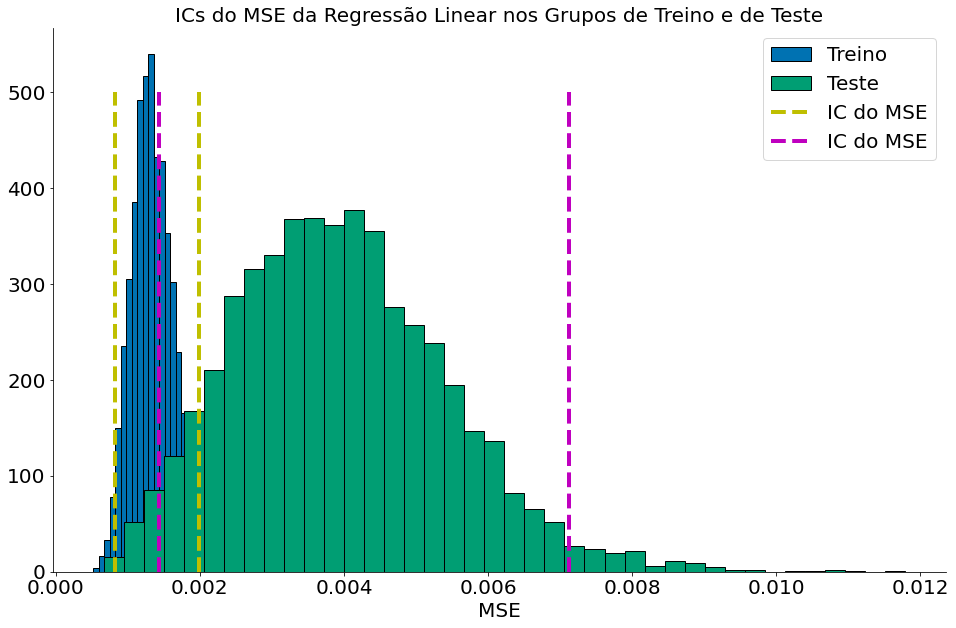

In [96]:
mse_values = bootstrap_mse(X_train, y_train, linear)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

ymin = 0
ymax = 500

plt.hist(mse_values, bins=30, label='Treino', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='y')
plt.vlines(LS, ymin, ymax, linestyles='--', color='y')

mse_values = bootstrap_mse(X_test, y_test, linear)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=40, label='Teste', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, ymin, ymax, linestyles='--', color='m')

plt.xlabel('MSE')
plt.title('ICs do MSE da Regressão Linear nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

#### 2. Lasso no Grupo de Teste <a name="lassoteste"></a>

O IC do Lasso aumenta bastante também, e ele piora em relação à Regressão Linear.

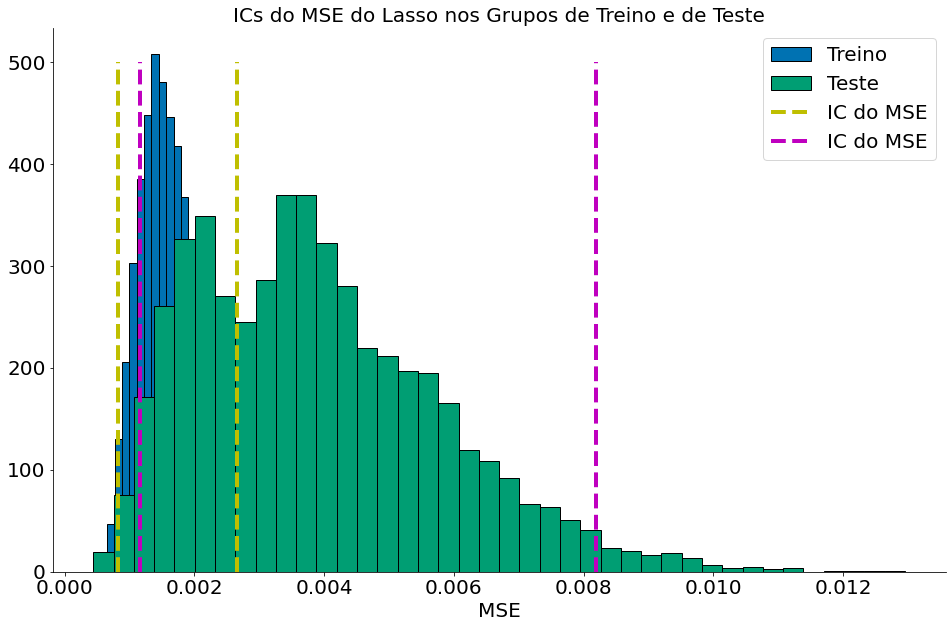

In [97]:
mse_values = bootstrap_mse(X_train, y_train, lasso)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

ymin = 0
ymax = 500

plt.hist(mse_values, bins=30, label='Treino', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='y')
plt.vlines(LS, ymin, ymax, linestyles='--', color='y')

mse_values = bootstrap_mse(X_test, y_test, lasso)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=40, label='Teste', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, ymin, ymax, linestyles='--', color='m')

plt.xlabel('MSE')
plt.title('ICs do MSE do Lasso nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

#### 3. Ridge no Grupo de Teste <a name="ridgeteste"></a>

Já o Ridge melhora bastante, e mostra que é bom generalizador, já que seus ICs são os mais parecidos em tamanho, até agora.

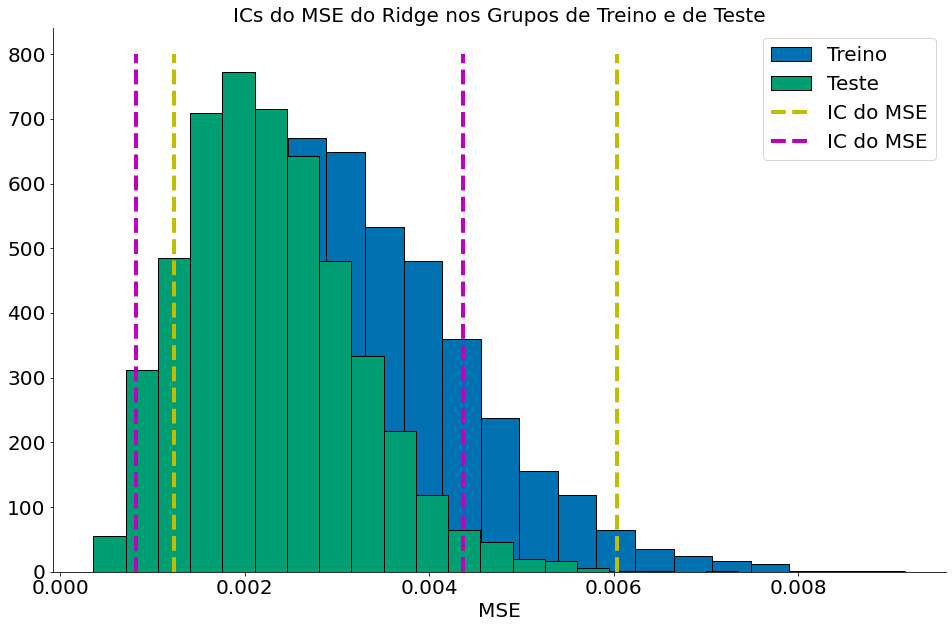

In [98]:
mse_values = bootstrap_mse(X_train, y_train, ridge)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

ymin = 0
ymax = 800

plt.hist(mse_values, bins=20, label='Treino', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='y')
plt.vlines(LS, ymin, ymax, linestyles='--', color='y')

mse_values = bootstrap_mse(X_test, y_test, ridge)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=20, label='Teste', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, ymin, ymax, linestyles='--', color='m')

plt.xlabel('MSE')
plt.title('ICs do MSE do Ridge nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

#### 4. KNN no Grupo de Teste <a name="knnteste"></a>

Como se esperava, o KNN decorou os dados de treino e não sabe generalizar, se mostrando pior que a Regressão Linear que é bem mais simples e rápida.

O gráfico foi cortado para permitir a visualização da distribuição do MSE do grupo de teste.

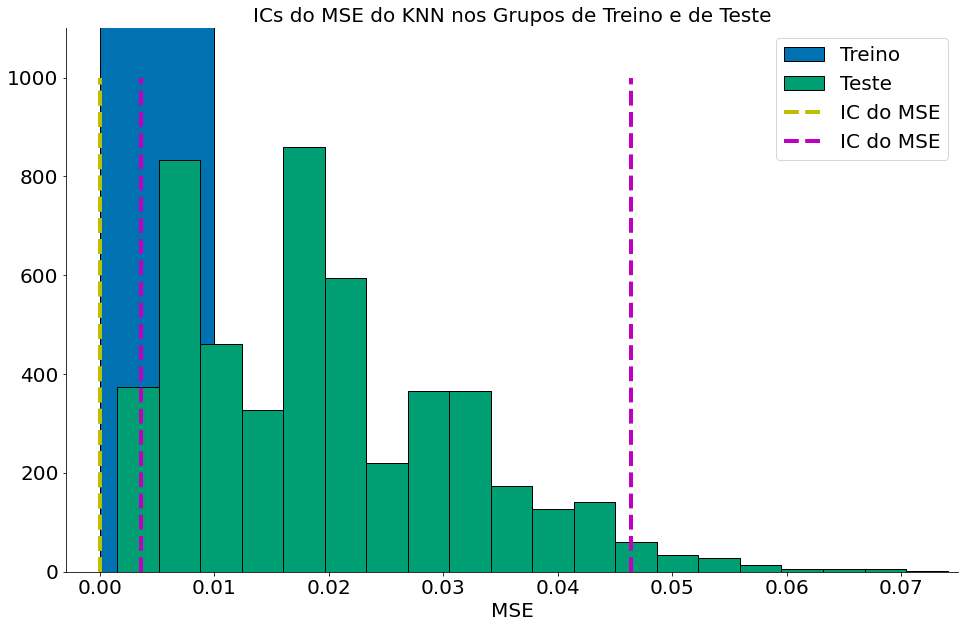

In [102]:
mse_values = bootstrap_mse(X_train, y_train, knn)

LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

ymin = 0
ymax = 1000

plt.hist(mse_values, bins=100, label='Treino', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='y')
plt.vlines(LS, ymin, ymax, linestyles='--', color='y')

mse_values = bootstrap_mse(X_test, y_test, knn)
LI = np.percentile(mse_values, 2.5)
LS = np.percentile(mse_values, 97.5)

plt.hist(mse_values, bins=20, label='Teste', edgecolor='k')
plt.vlines(LI, ymin, ymax, linestyles='--', label='IC do MSE', color='m')
plt.vlines(LS, ymin, ymax, linestyles='--', color='m')

plt.xlabel('MSE')
plt.title('ICs do MSE do KNN nos Grupos de Treino e de Teste')

plt.legend()

plt.xlim(-0.003, 0.075)
plt.ylim(top=ymax * 1.1)

despine()

plt.show()

### 3. Melhor Modelo e Parâmetros <a name="melhor"></a>

O Ridge se mostrou o melhor modelo para generalizar o aprendizado obtido com os dados de treino.

## 9. Conclusão <a name="concl"></a>

O projeto criou oportunidades para o aprendizado de várias técnicas, conceitos e ferramentas do arcabouço de Ciência de Dados. Além do mais, foi possível perceber a importância de apresentar os dados de forma a aumentar a legibilidade deles pelo leitor.

Autor: Lucas S. Teles